# Multi-Layer Perceptron, MNIST

### import libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc


## Load and Visualize the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0

batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

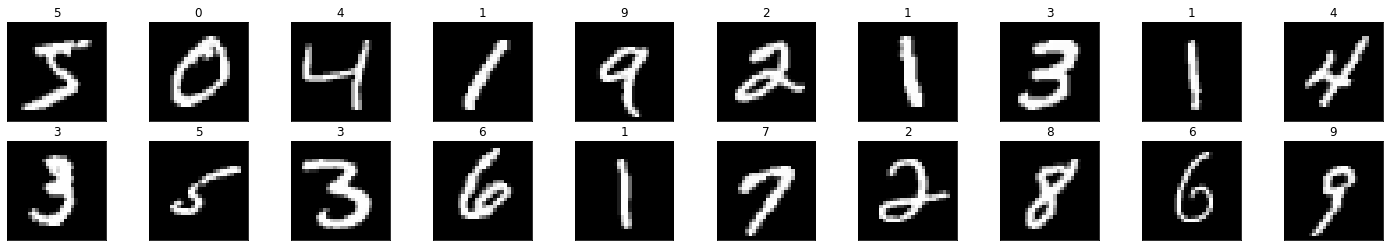

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


### View an Image in More Detail

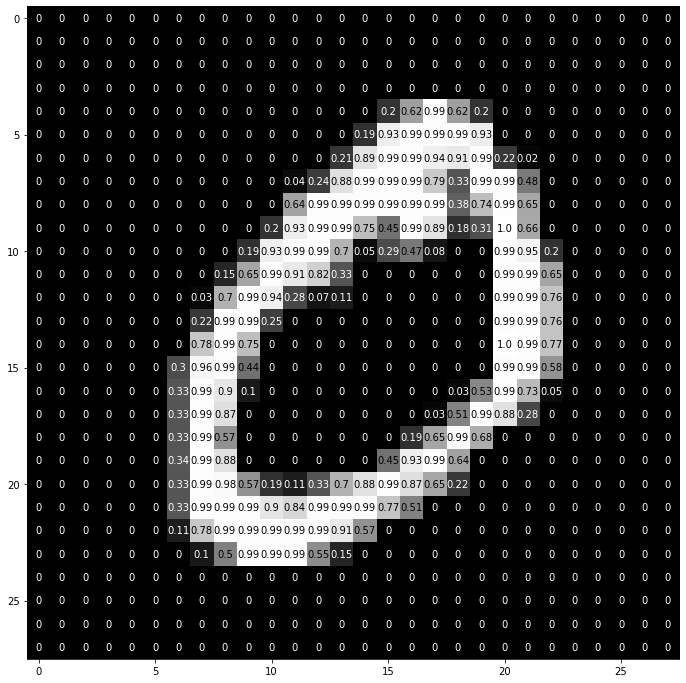

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


##  Network


In [5]:
def mlp_model(activation_selected, loss_selected, optimiz_selected, num_epochs):
  print(f"Activation function : {activation_selected}")
  print(f"Loss function : {loss_selected}")
  print(f"optimizer : {optimiz_selected}")
  print(f"Number of epochs : {num_epochs}")
  print ('-'*100 )

  # Model
  class Net(nn.Module):
      def __init__(self, activ):
          super(Net, self).__init__()
          self.fc1 = nn.Linear(784, 256) # fully connected layer 1
          self.fc2 = nn.Linear(256, 128) # fully connected layer 2
          self.fc3 = nn.Linear(128, 10) # fully connected layer 3     
          self.active_fun = select_active_function(activ) # activation function

      def forward(self, x):
          out = self.fc1(x)
          out = self.active_fun(out)
          out = self.fc2(out)
          out = self.active_fun(out)
          out = self.fc3(out)
          return out     

  # Select loss function
  def select_loss_function(loss_fun):
    if loss_fun == 'CrossEntropyLoss':
      return nn.CrossEntropyLoss()
    elif  loss_fun == 'NLLLoss':
      return nn.NLLLoss()

  # Select optimizer
  def select_optimiz(optimiz):
    if optimiz == 'SGD':
      return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif  optimiz == 'Adam':
      return optim.Adam(model.parameters(), lr=0.01)
    elif  optimiz == 'Adagrad':
      return optim.Adagrad(model.parameters(), lr=0.01)

  # Select active function
  def select_active_function(activation):
    if activation == 'ReLU':
      return nn.ReLU()
    elif  activation == 'Sigmoid':
      return nn.Sigmoid()
    elif  activation == 'Tanh':
      return nn.Tanh()

  # set the device to be used for training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = Net(activation_selected).to(device)

  # Select criterion and optimizer
  criterion = select_loss_function(loss_selected)
  optimizer = select_optimiz(optimiz_selected)

  # Train
  for epoch in range(num_epochs):
      running_loss = 0
      for i, (images, labels) in enumerate(train_loader):
          images, labels = images.to(device), labels.to(device)
          
          # flatten the images into a vector
          images = images.view(-1, 784)
          
          # forward pass through the network
          outputs = model(images)
          
          # calculate the loss
          loss = criterion(outputs, labels)
          
          # backpropagation and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # update the running loss
          running_loss += loss.item()
          
          # print some statistics every few batches
          if (i+1) % 200 == 0:
              print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
              running_loss = 0.0

  print ('-'*100 )


  # Test
  test_loss = 0
  with torch.no_grad():
      correct = 0
      total = 0
      
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          # Flatten the images
          images = images.view(-1, 784)
          
          # Forward pass  
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          # Calculate the loss
          loss = criterion(outputs, labels)
          test_loss += loss.item()
          
          # Calculate the accuracy
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      
      print('Test Accuracy of the model : {} %'.format(100 * correct / total))

  print ('-'*100 )

  # to cpu and array
  y_pred = np.array(predicted.cpu())
  y_test = np.array(labels.cpu())
  print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

  print ('-'*100 )


  ## TODO: calculate and print avg test loss
  test_loss = test_loss / len(test_loader)
  print('Test Loss: {:.6f}'.format(test_loss))

  print ('-'*100 )


  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  images, labels = images.to(device), labels.to(device)
  images = images.view(-1, 784)

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds = torch.max(output, 1)
  # prep images for display
  images = images.cpu().numpy()

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 30))
  for idx in np.arange(20):
      ax = fig.add_subplot(5, 20//4, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx].reshape(28, 28)), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                  color=("green" if preds[idx]==labels[idx] else "red"))

  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy:', accuracy)

  print ('-'*100 )


  confusion = confusion_matrix(y_test, y_pred)
  print('confusion matrix:')
  print(confusion)

  print ('-'*100 )


  f1_score_list = f1_score(y_test, y_pred, average=None)

  for i, f1_scoree in enumerate(f1_score_list):
      print('f1_score for class {} is: {}'.format(i, f1_scoree))

  print ('-'*100 )


  y_score = []
  for x in y_pred:
      temp = [0]*10
      temp[x] = 1
      y_score.append(temp)
  y_score_df = pd.DataFrame(y_score)
  y_score_df= y_score_df.fillna(0)
  y_score = y_score_df.to_numpy()
  print(y_score)

  print ('-'*100 )
  


  n_classes = 10
  y_test_binery = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_binery[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot of a ROC curve for a specific class
  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], label='ROC curve (auc = %0.6f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver operating characteristic for class {}'.format(i))
      plt.legend(loc="lower right")
      plt.show()
      print('\n')


  print ('-'*100 )

  # First aggregate all false positive rates
  n_classes = 10
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binery.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (auc = {0:0.6f})".format(roc_auc["micro"]),
      color="pink",
      linewidth=5,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label="macro-average ROC curve (auc = {0:0.6f})".format(roc_auc["macro"]),
      color="navy",
      linestyle=":",
      linewidth=5,
  )

  plt.plot([0, 1], [0, 1], "k--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()


##  run Network

ReLU, CrossEntropyLoss, SGD

Activation function : ReLU
Loss function : CrossEntropyLoss
optimizer : SGD
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 2.5940
Epoch [1/10], Step [400/938], Loss: 0.8250
Epoch [1/10], Step [600/938], Loss: 0.6819
Epoch [1/10], Step [800/938], Loss: 0.6259
Epoch [2/10], Step [200/938], Loss: 0.4528
Epoch [2/10], Step [400/938], Loss: 0.4045
Epoch [2/10], Step [600/938], Loss: 0.3833
Epoch [2/10], Step [800/938], Loss: 0.3749
Epoch [3/10], Step [200/938], Loss: 0.2857
Epoch [3/10], Step [400/938], Loss: 0.2639
Epoch [3/10], Step [600/938], Loss: 0.2647
Epoch [3/10], Step [800/938], Loss: 0.2650
Epoch [4/10], Step [200/938], Loss: 0.2062
Epoch [4/10], Step [400/938], Loss: 0.1949
Epoch [4/10], Step [600/938], Loss: 0.1977
Epoch [4/10], Step [800/938], Loss: 0.2034
Epoch [5/10], Step [200/938], Loss: 0.1595
Epoch [5/10], Step [400/938], Loss: 0.1528
Epoch [5/10], Step [600/938

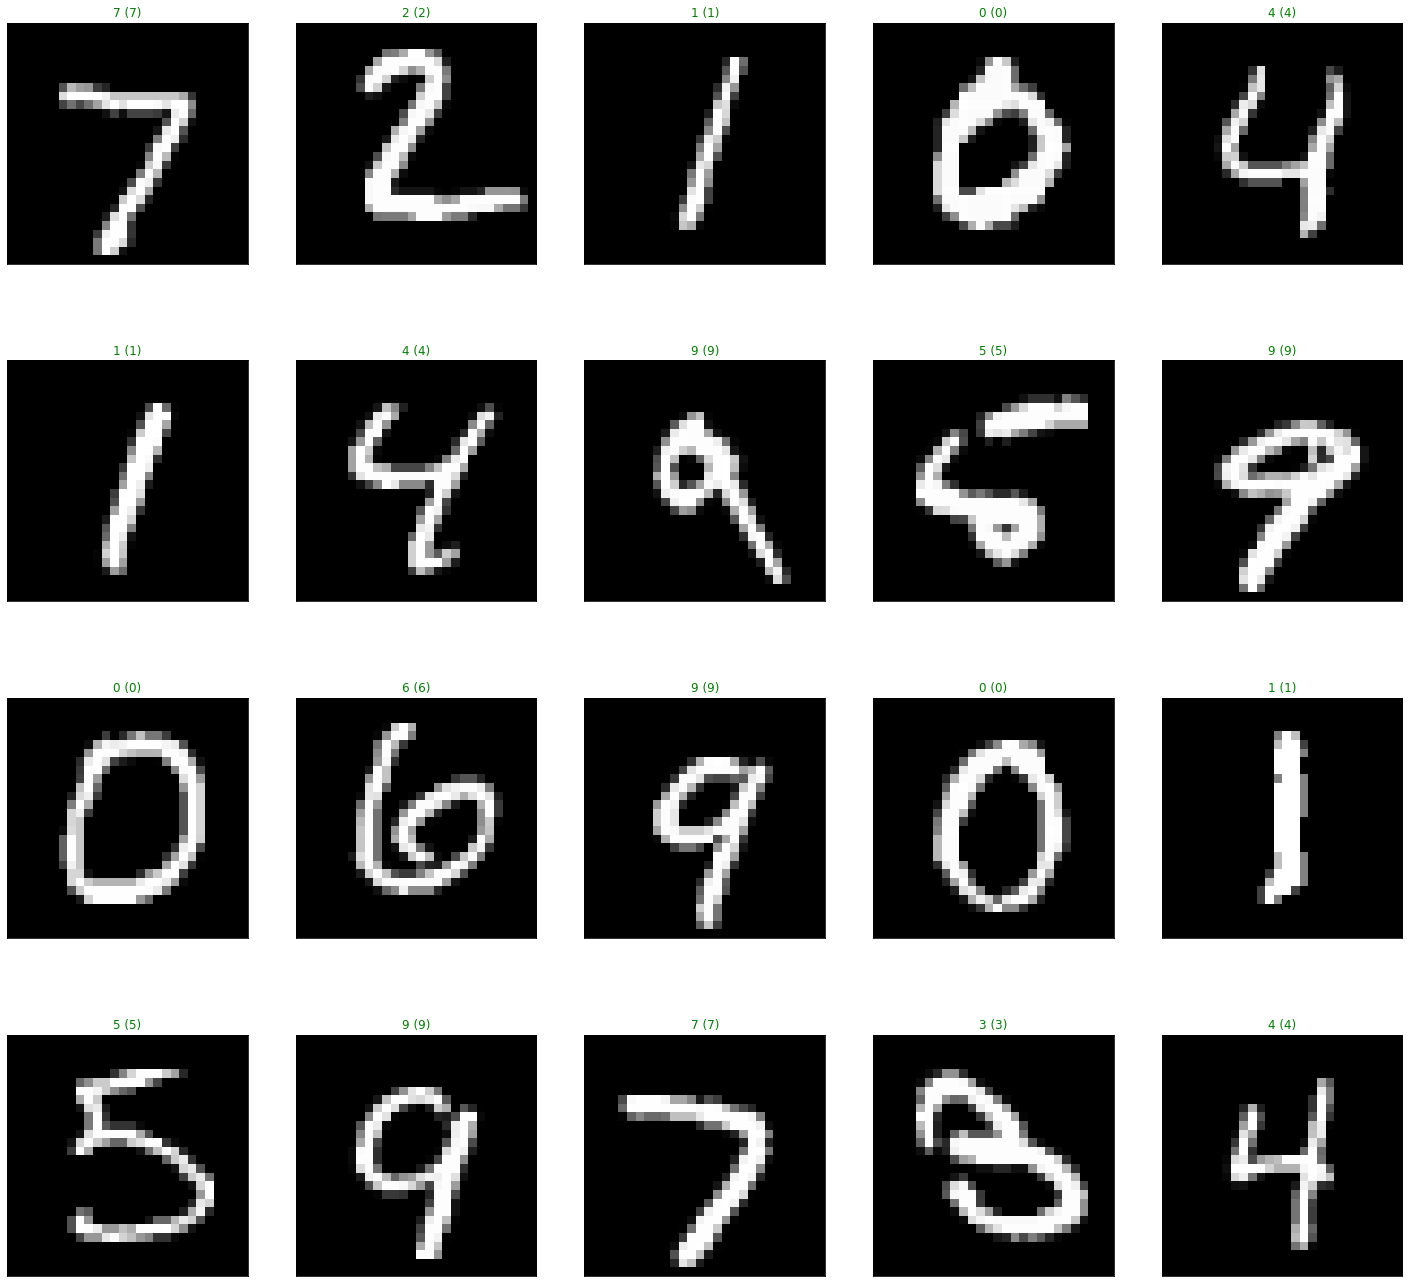

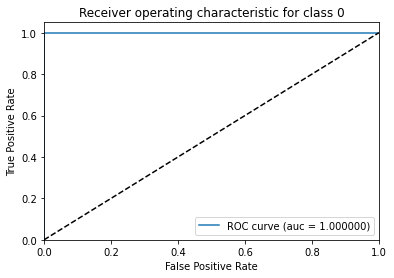

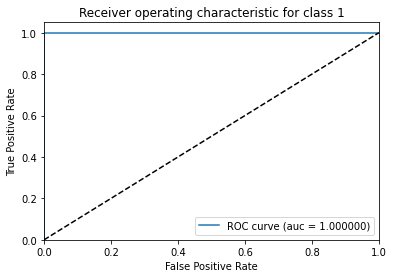

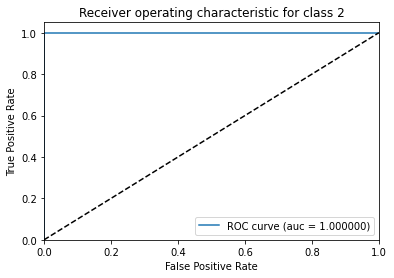

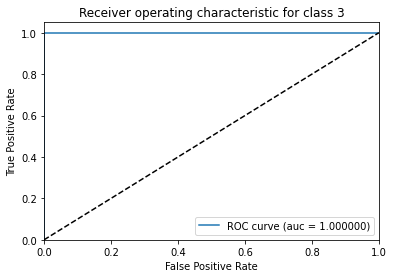

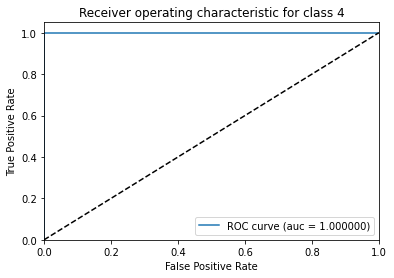

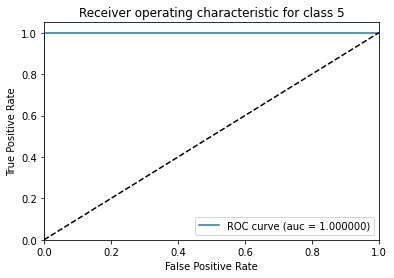

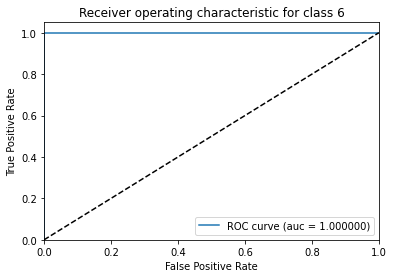

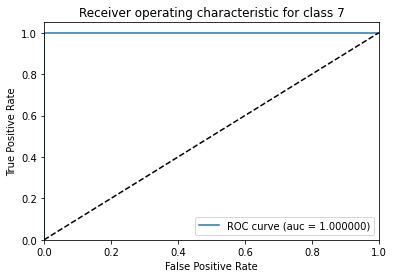

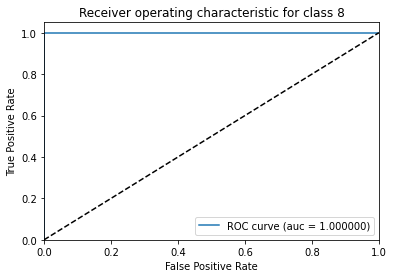

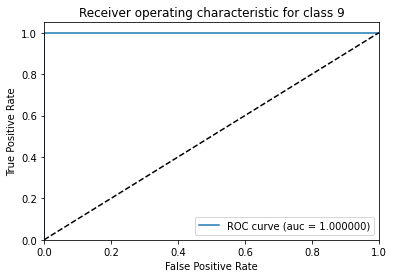



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


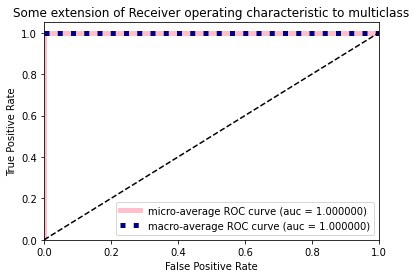

In [6]:
model1 = mlp_model("ReLU", "CrossEntropyLoss", "SGD", 10)

ReLU, CrossEntropyLoss, Adam

Activation function : ReLU
Loss function : CrossEntropyLoss
optimizer : Adam
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 0.8644
Epoch [1/10], Step [400/938], Loss: 0.5189
Epoch [1/10], Step [600/938], Loss: 0.4651
Epoch [1/10], Step [800/938], Loss: 0.4394
Epoch [2/10], Step [200/938], Loss: 0.3568
Epoch [2/10], Step [400/938], Loss: 0.3397
Epoch [2/10], Step [600/938], Loss: 0.3363
Epoch [2/10], Step [800/938], Loss: 0.3591
Epoch [3/10], Step [200/938], Loss: 0.2859
Epoch [3/10], Step [400/938], Loss: 0.3039
Epoch [3/10], Step [600/938], Loss: 0.2722
Epoch [3/10], Step [800/938], Loss: 0.2950
Epoch [4/10], Step [200/938], Loss: 0.2833
Epoch [4/10], Step [400/938], Loss: 0.2512
Epoch [4/10], Step [600/938], Loss: 0.2541
Epoch [4/10], Step [800/938], Loss: 0.2621
Epoch [5/10], Step [200/938], Loss: 0.2391
Epoch [5/10], Step [400/938], Loss: 0.2475
Epoch [5/10], Step [600/93

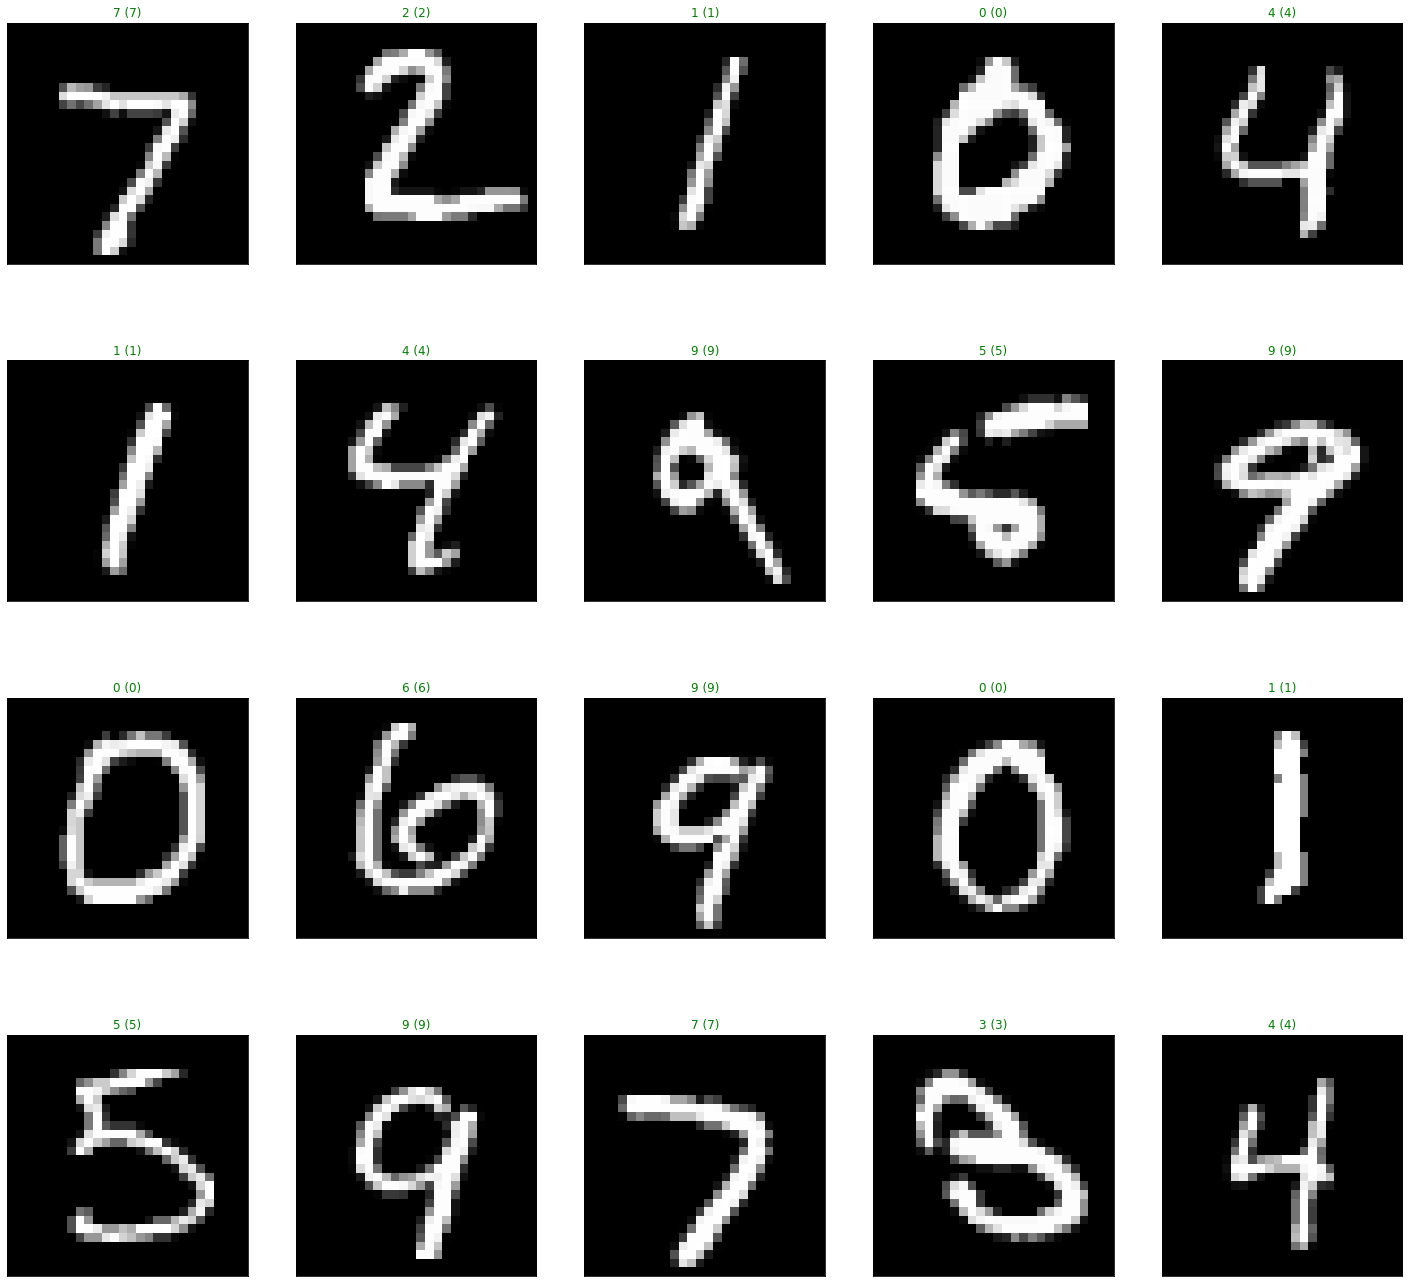

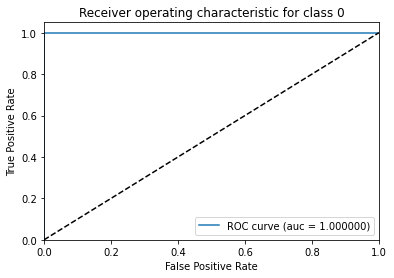

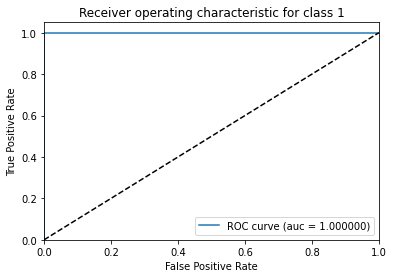

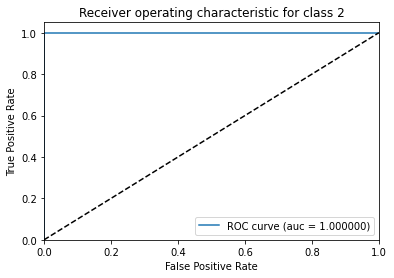

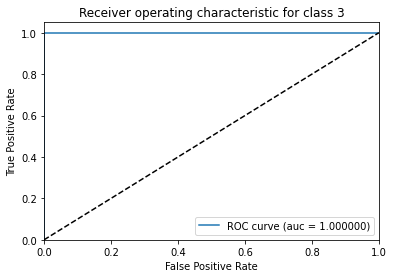

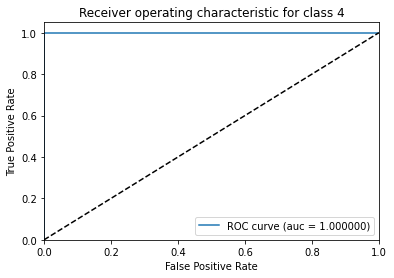

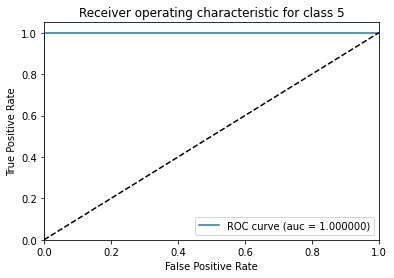

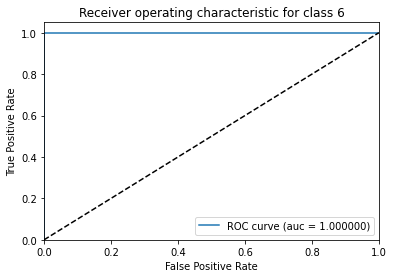

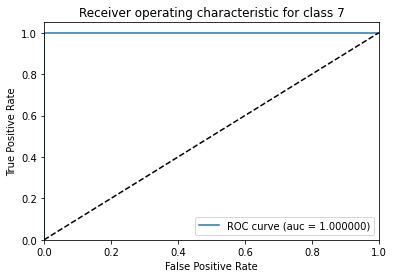

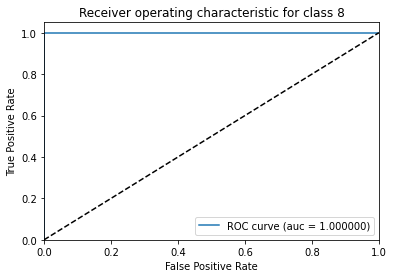

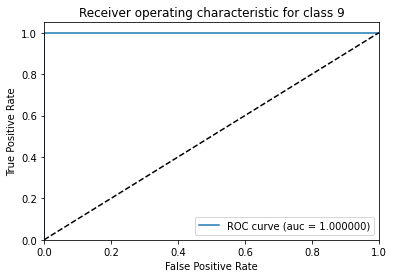



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


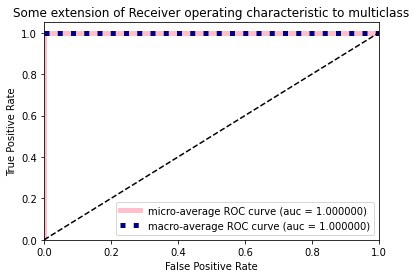

In [7]:
model2 = mlp_model("ReLU", "CrossEntropyLoss", "Adam", 10)

ReLU, CrossEntropyLoss, Adagrad

Activation function : ReLU
Loss function : CrossEntropyLoss
optimizer : Adagrad
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 0.8254
Epoch [1/10], Step [400/938], Loss: 0.4380
Epoch [1/10], Step [600/938], Loss: 0.3720
Epoch [1/10], Step [800/938], Loss: 0.3406
Epoch [2/10], Step [200/938], Loss: 0.2456
Epoch [2/10], Step [400/938], Loss: 0.2300
Epoch [2/10], Step [600/938], Loss: 0.2322
Epoch [2/10], Step [800/938], Loss: 0.2363
Epoch [3/10], Step [200/938], Loss: 0.1791
Epoch [3/10], Step [400/938], Loss: 0.1716
Epoch [3/10], Step [600/938], Loss: 0.1785
Epoch [3/10], Step [800/938], Loss: 0.1885
Epoch [4/10], Step [200/938], Loss: 0.1439
Epoch [4/10], Step [400/938], Loss: 0.1388
Epoch [4/10], Step [600/938], Loss: 0.1468
Epoch [4/10], Step [800/938], Loss: 0.1581
Epoch [5/10], Step [200/938], Loss: 0.1210
Epoch [5/10], Step [400/938], Loss: 0.1166
Epoch [5/10], Step [600

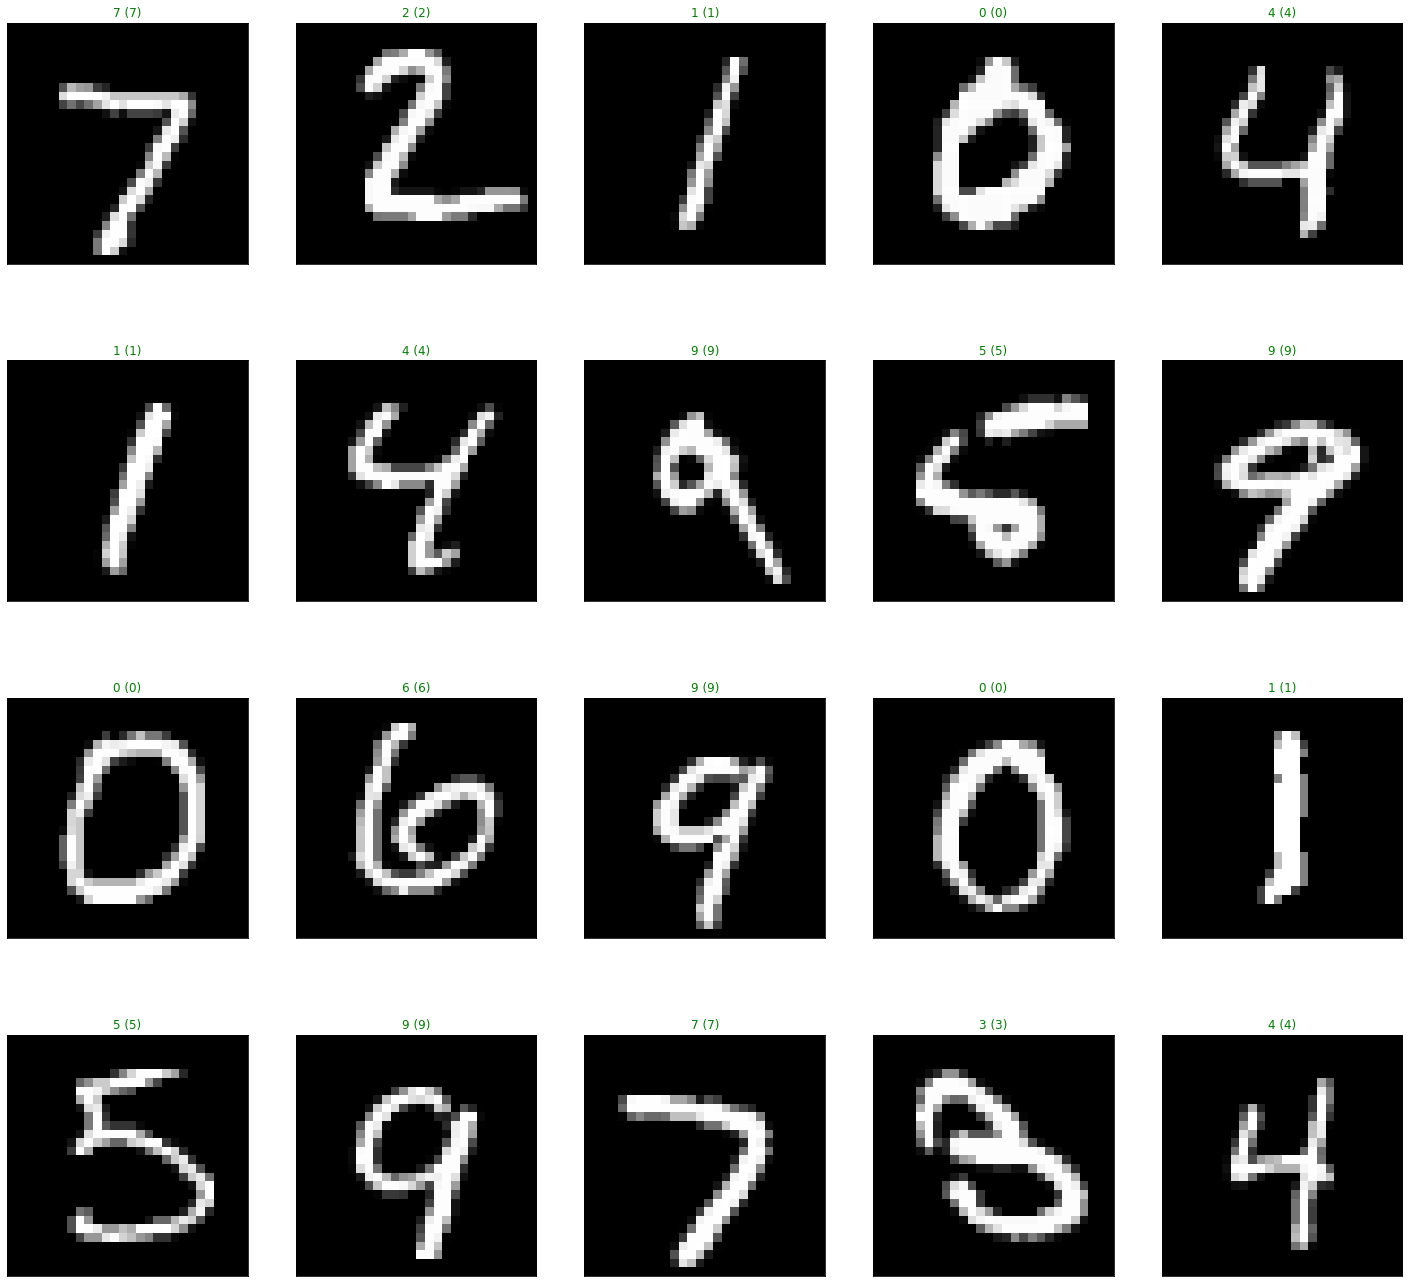

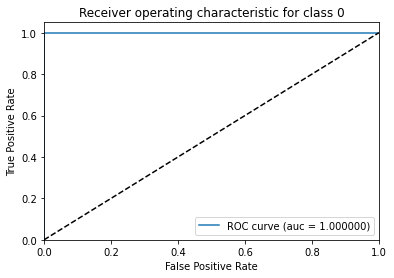

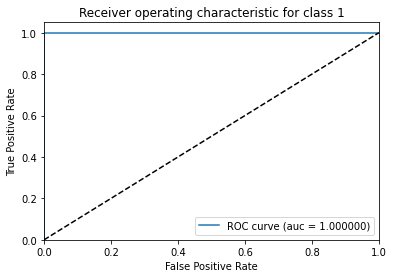

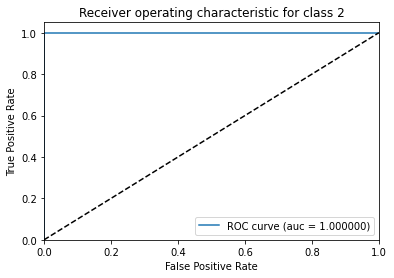

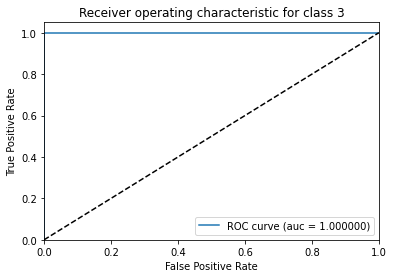

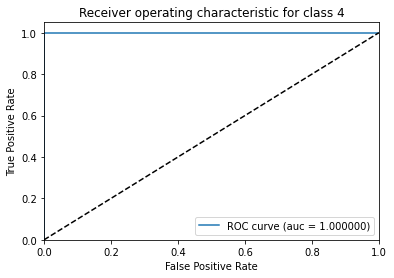

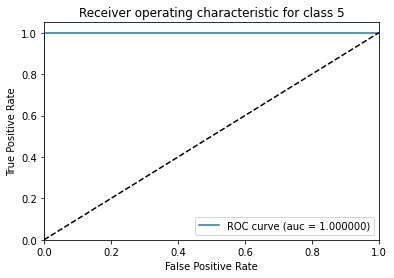

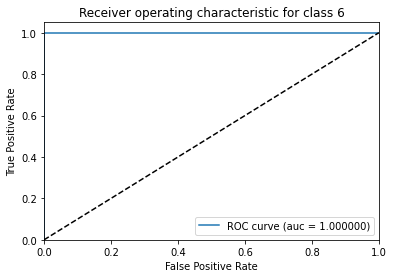

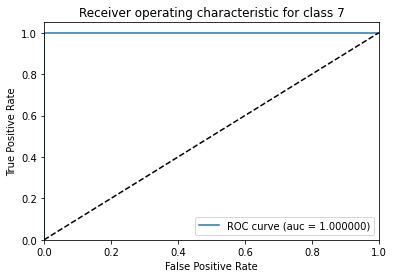

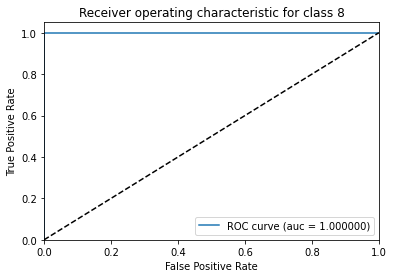

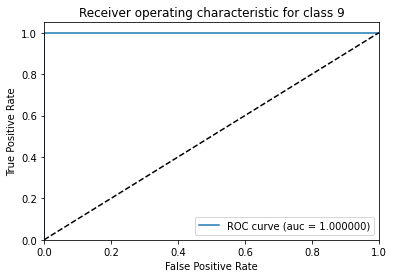



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


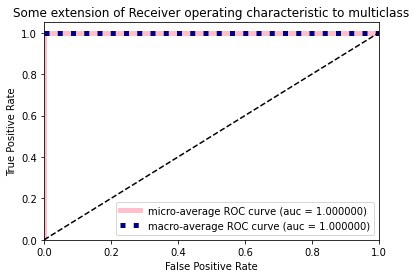

In [8]:
model3 = mlp_model("ReLU", "CrossEntropyLoss", "Adagrad", 10)

ReLU, NLLLoss, SGD

Activation function : ReLU
Loss function : NLLLoss
optimizer : SGD
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: nan
Epoch [1/10], Step [400/938], Loss: nan
Epoch [1/10], Step [600/938], Loss: nan
Epoch [1/10], Step [800/938], Loss: nan
Epoch [2/10], Step [200/938], Loss: nan
Epoch [2/10], Step [400/938], Loss: nan
Epoch [2/10], Step [600/938], Loss: nan
Epoch [2/10], Step [800/938], Loss: nan
Epoch [3/10], Step [200/938], Loss: nan
Epoch [3/10], Step [400/938], Loss: nan
Epoch [3/10], Step [600/938], Loss: nan
Epoch [3/10], Step [800/938], Loss: nan
Epoch [4/10], Step [200/938], Loss: nan
Epoch [4/10], Step [400/938], Loss: nan
Epoch [4/10], Step [600/938], Loss: nan
Epoch [4/10], Step [800/938], Loss: nan
Epoch [5/10], Step [200/938], Loss: nan
Epoch [5/10], Step [400/938], Loss: nan
Epoch [5/10], Step [600/938], Loss: nan
Epoch [5/10], Step [800/938], Loss: nan
Epoch [6/1

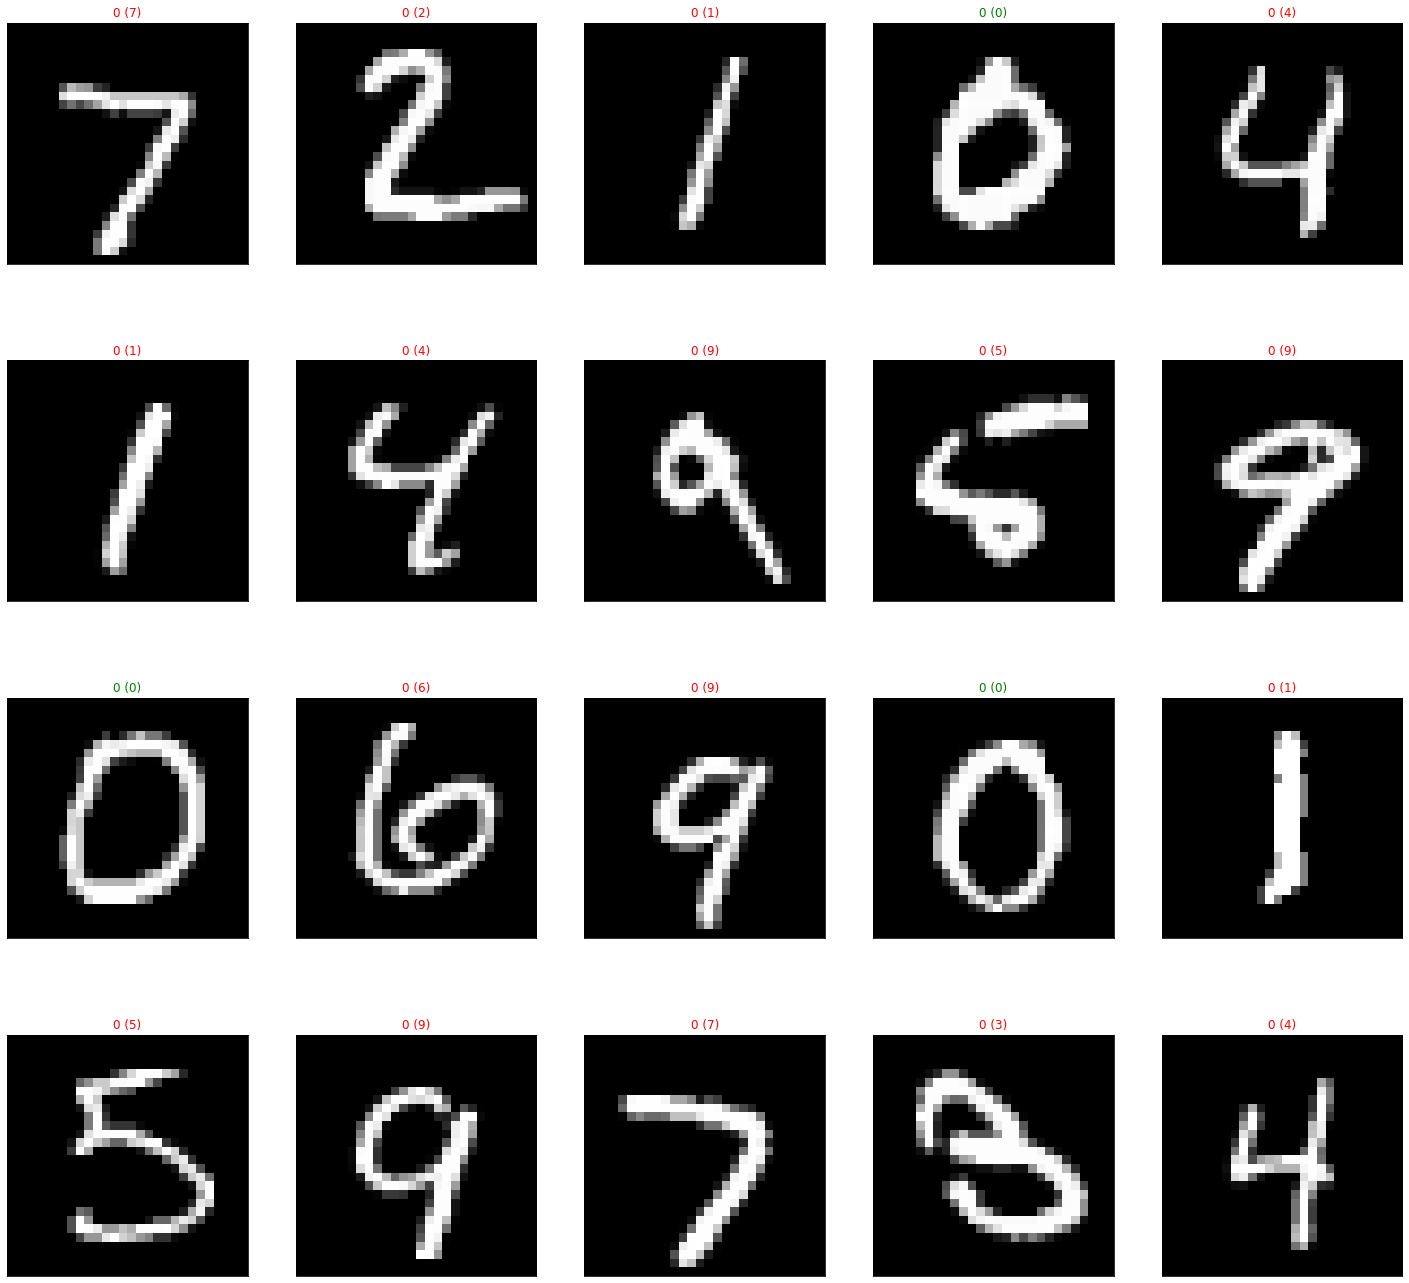

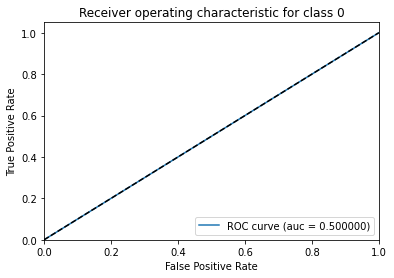

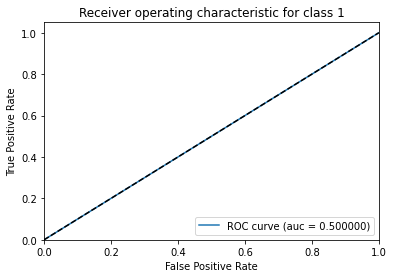

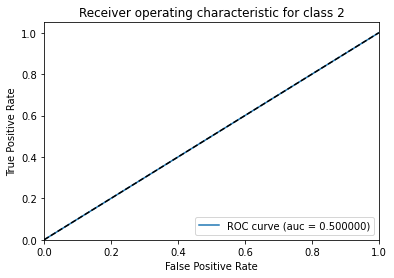

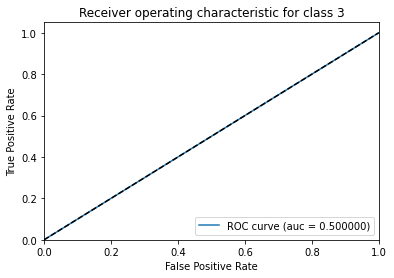

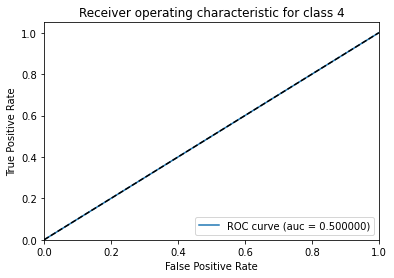

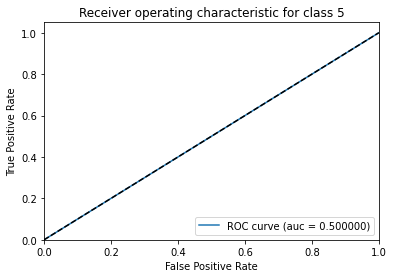

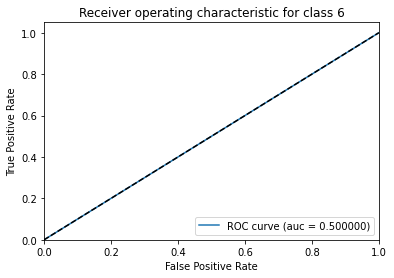

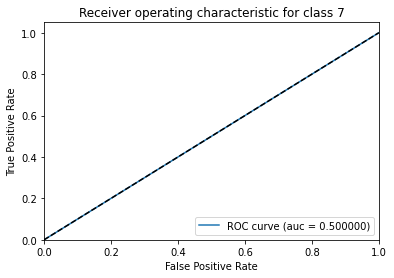

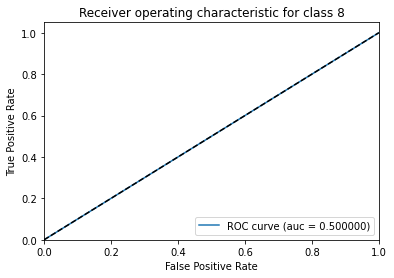

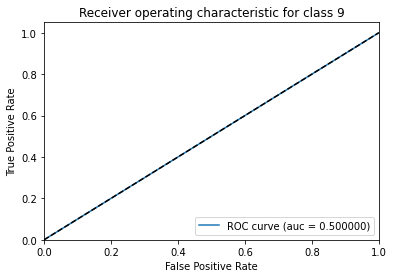



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


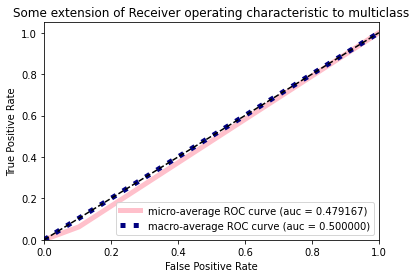

In [9]:
model4 = mlp_model("ReLU", "NLLLoss", "SGD", 10)

ReLU, NLLLoss, Adam

Activation function : ReLU
Loss function : NLLLoss
optimizer : Adam
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -25330629.2609
Epoch [1/10], Step [400/938], Loss: -538931789.0000
Epoch [1/10], Step [600/938], Loss: -2543728780.1600
Epoch [1/10], Step [800/938], Loss: -7009709012.4800
Epoch [2/10], Step [200/938], Loss: -22715921121.2800
Epoch [2/10], Step [400/938], Loss: -37501760020.4800
Epoch [2/10], Step [600/938], Loss: -56075769630.7200
Epoch [2/10], Step [800/938], Loss: -79942571540.4800
Epoch [3/10], Step [200/938], Loss: -135116704112.6400
Epoch [3/10], Step [400/938], Loss: -174284506030.0800
Epoch [3/10], Step [600/938], Loss: -216274949079.0400
Epoch [3/10], Step [800/938], Loss: -266248750120.9600
Epoch [4/10], Step [200/938], Loss: -372376080220.1600
Epoch [4/10], Step [400/938], Loss: -440135802388.4800
Epoch [4/10], Step [600/938], Loss: -507716456611.8400

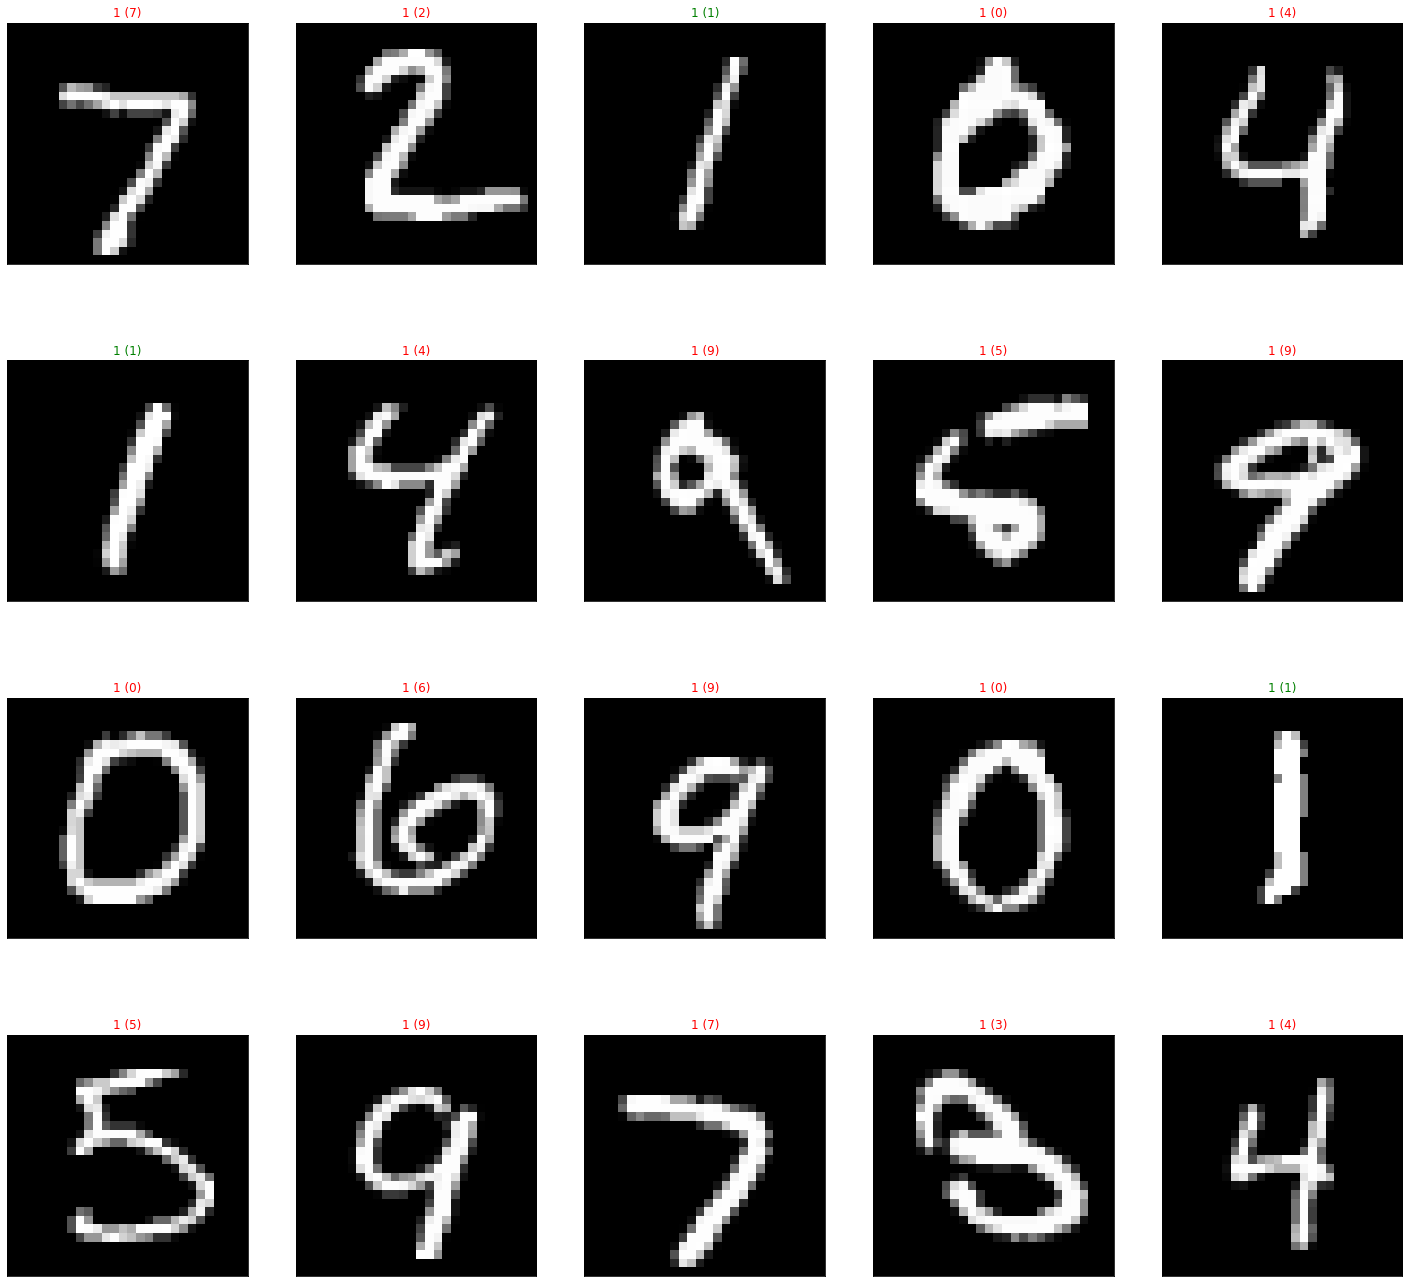

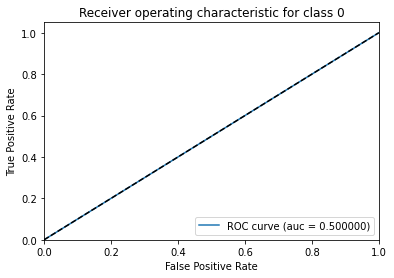

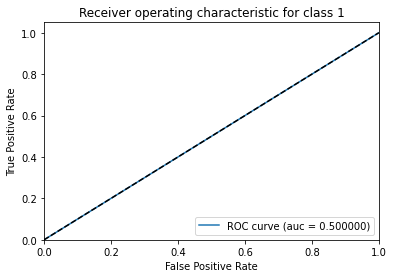

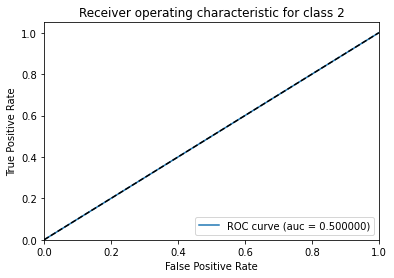

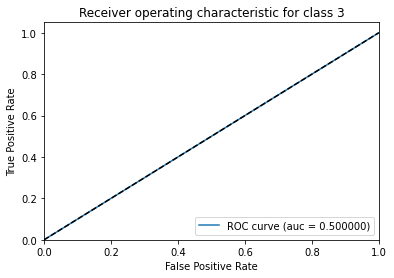

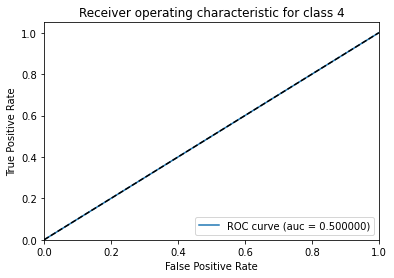

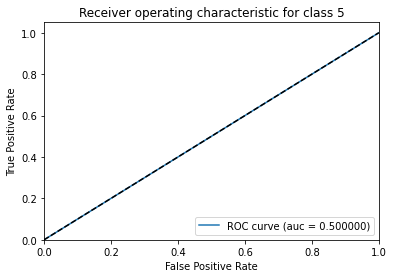

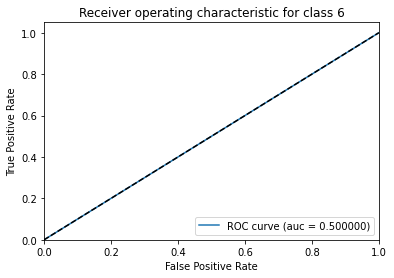

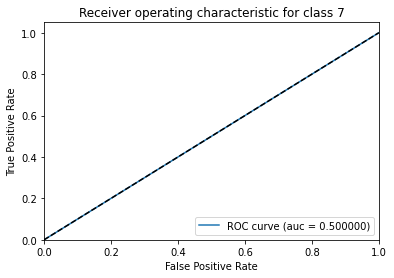

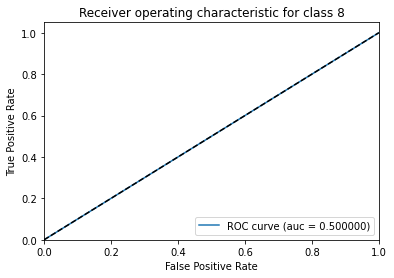

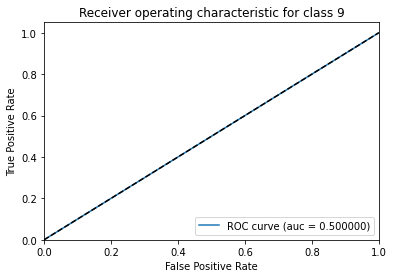



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


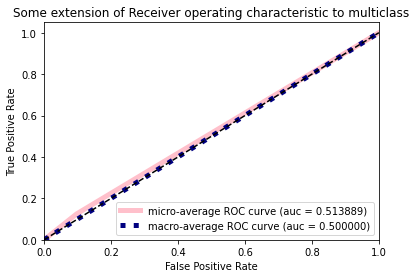

In [10]:
model5 = mlp_model("ReLU", "NLLLoss", "Adam", 10)

ReLU, NLLLoss, Adagrad

Activation function : ReLU
Loss function : NLLLoss
optimizer : Adagrad
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -92492.9553
Epoch [1/10], Step [400/938], Loss: -465377.2791
Epoch [1/10], Step [600/938], Loss: -1005979.3509
Epoch [1/10], Step [800/938], Loss: -1686567.9600
Epoch [2/10], Step [200/938], Loss: -3171135.6837
Epoch [2/10], Step [400/938], Loss: -4163286.3138
Epoch [2/10], Step [600/938], Loss: -5168640.9525
Epoch [2/10], Step [800/938], Loss: -6301400.1550
Epoch [3/10], Step [200/938], Loss: -8561500.6575
Epoch [3/10], Step [400/938], Loss: -9907549.3375
Epoch [3/10], Step [600/938], Loss: -11171941.0850
Epoch [3/10], Step [800/938], Loss: -12620999.7700
Epoch [4/10], Step [200/938], Loss: -15517025.1650
Epoch [4/10], Step [400/938], Loss: -17130340.4950
Epoch [4/10], Step [600/938], Loss: -18563442.5050
Epoch [4/10], Step [800/938], Loss: -20267620.1450
Epo

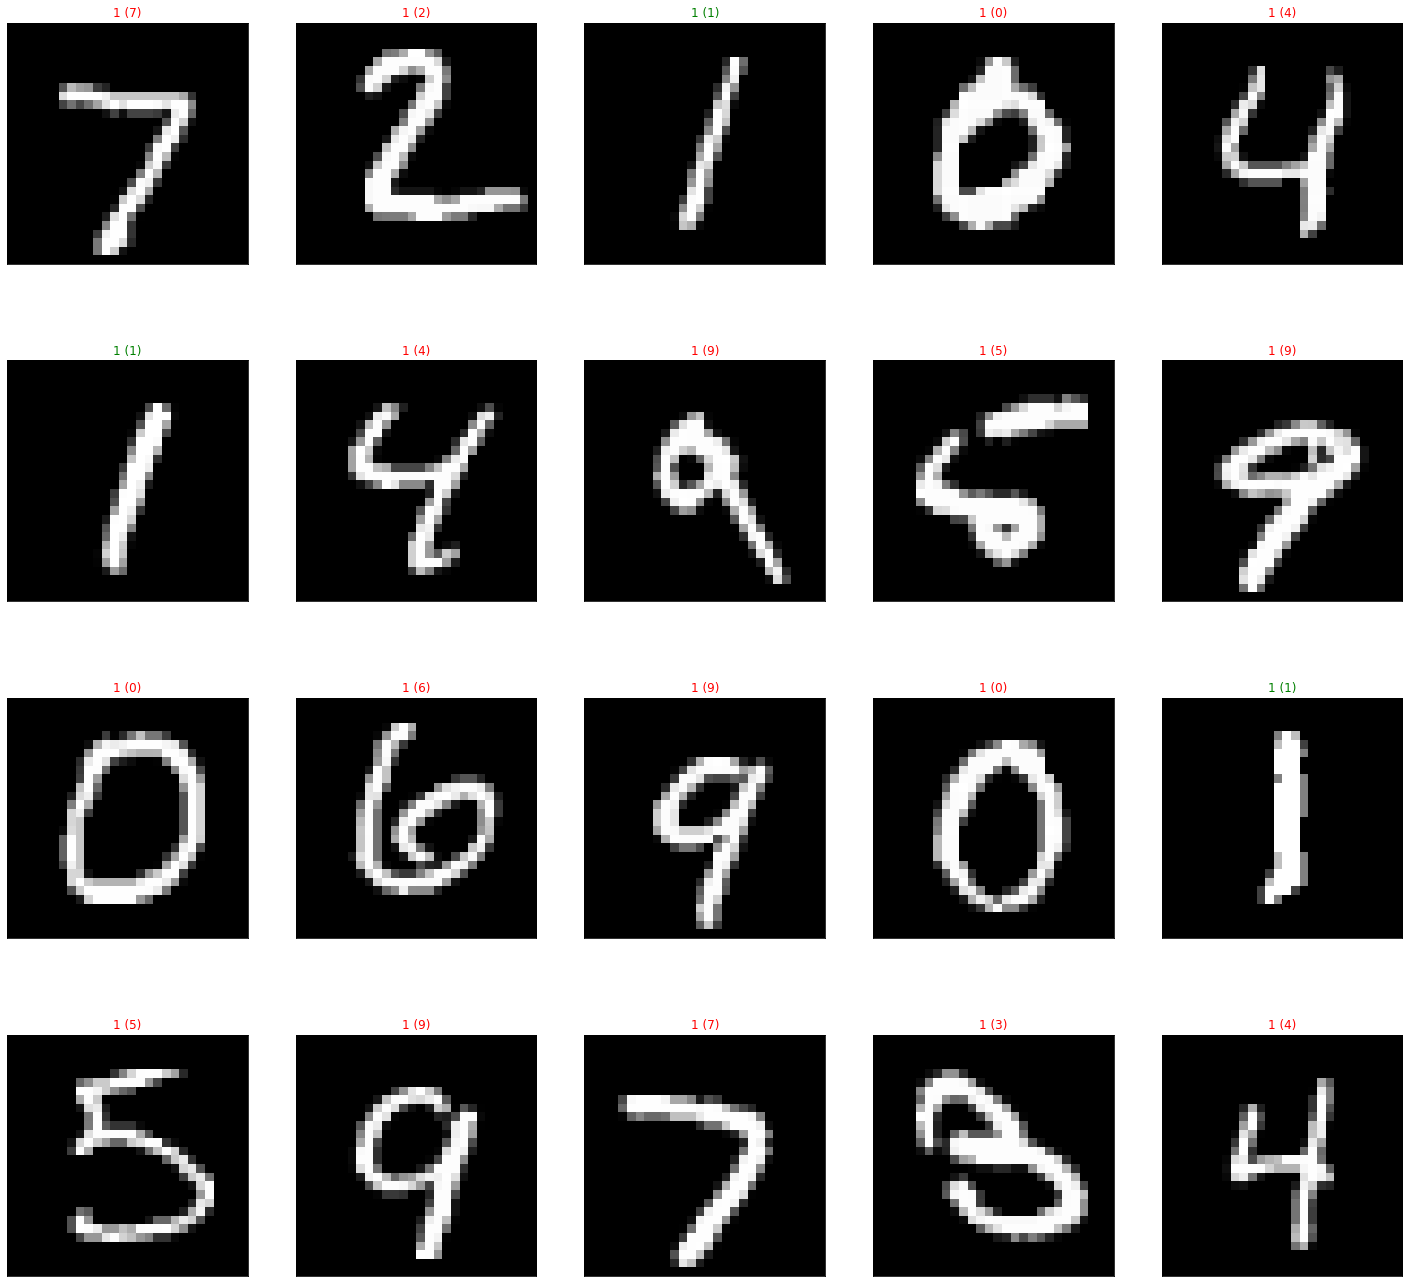

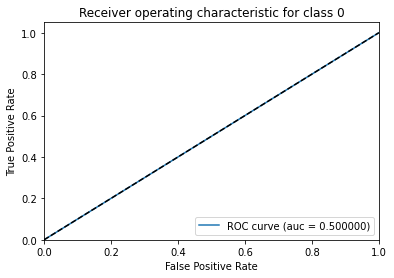

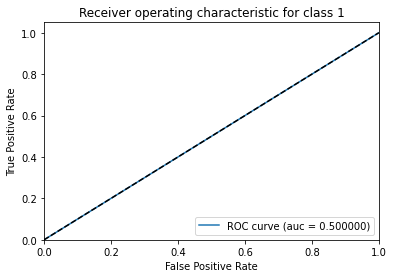

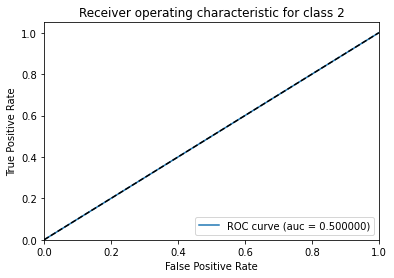

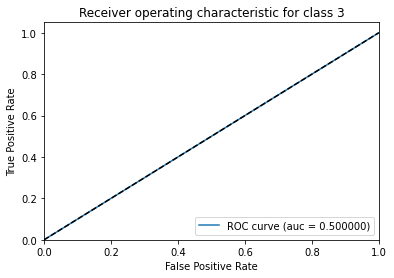

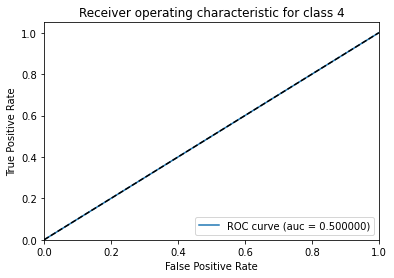

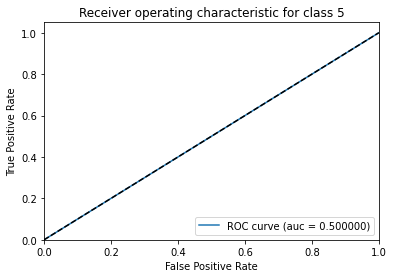

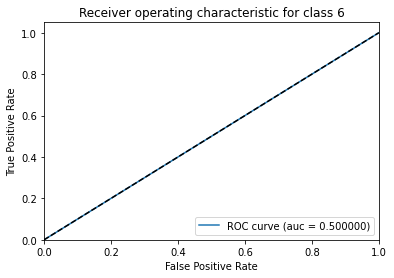

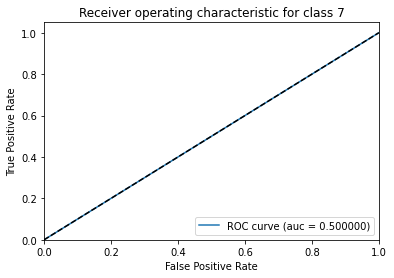

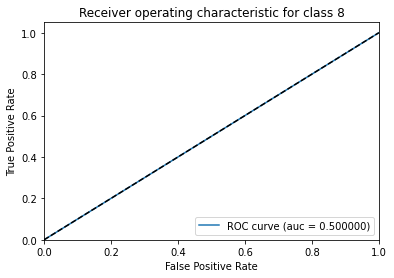

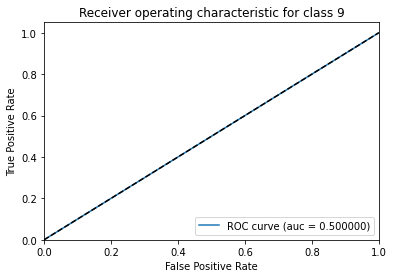



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


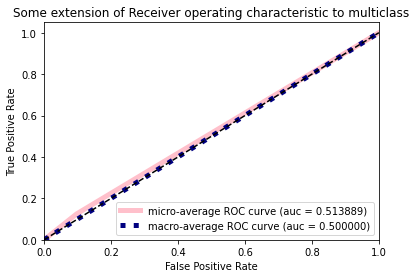

In [11]:
model6 = mlp_model("ReLU", "NLLLoss", "Adagrad", 10)

Sigmoid, CrossEntropyLoss, SGD

Activation function : Sigmoid
Loss function : CrossEntropyLoss
optimizer : SGD
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 4.6100
Epoch [1/10], Step [400/938], Loss: 4.5550
Epoch [1/10], Step [600/938], Loss: 4.3665
Epoch [1/10], Step [800/938], Loss: 3.5233
Epoch [2/10], Step [200/938], Loss: 1.9438
Epoch [2/10], Step [400/938], Loss: 1.6407
Epoch [2/10], Step [600/938], Loss: 1.4424
Epoch [2/10], Step [800/938], Loss: 1.2508
Epoch [3/10], Step [200/938], Loss: 1.0143
Epoch [3/10], Step [400/938], Loss: 0.9647
Epoch [3/10], Step [600/938], Loss: 0.9359
Epoch [3/10], Step [800/938], Loss: 0.8939
Epoch [4/10], Step [200/938], Loss: 0.7977
Epoch [4/10], Step [400/938], Loss: 0.7886
Epoch [4/10], Step [600/938], Loss: 0.7908
Epoch [4/10], Step [800/938], Loss: 0.7756
Epoch [5/10], Step [200/938], Loss: 0.7043
Epoch [5/10], Step [400/938], Loss: 0.7055
Epoch [5/10], Step [600/

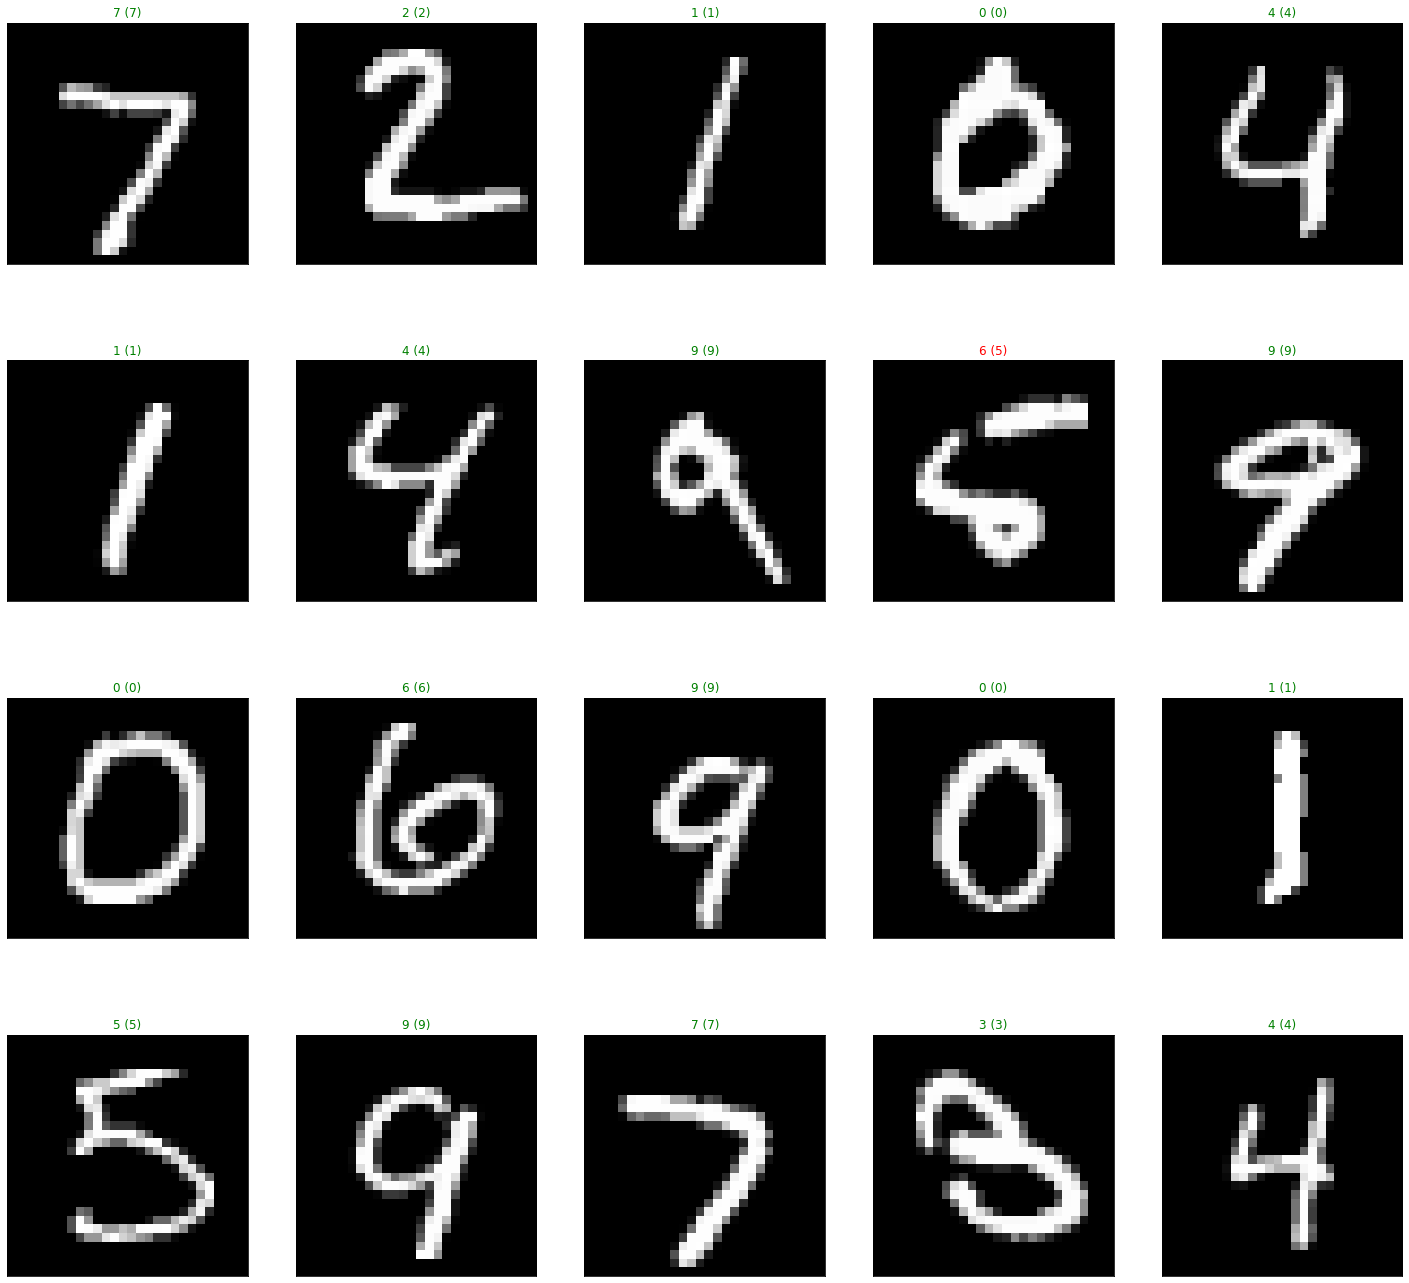

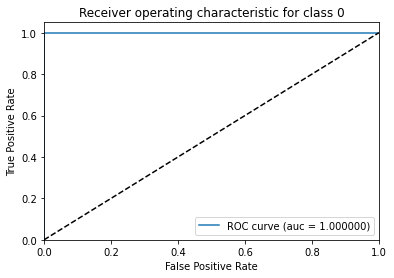

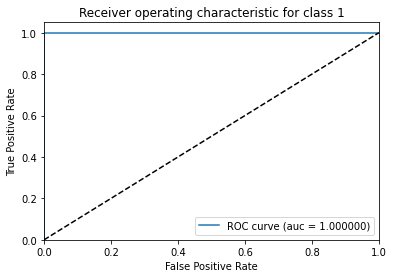

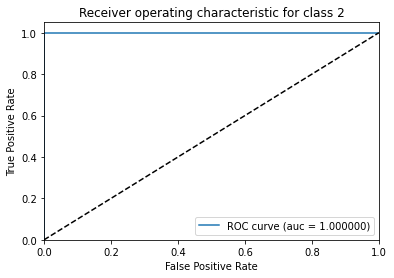

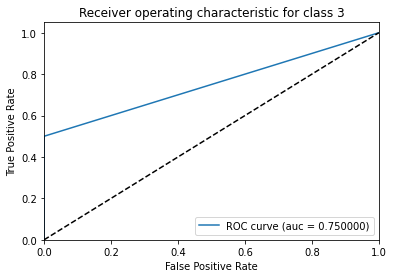

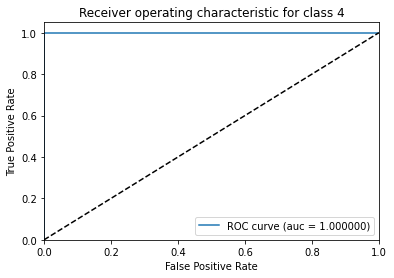

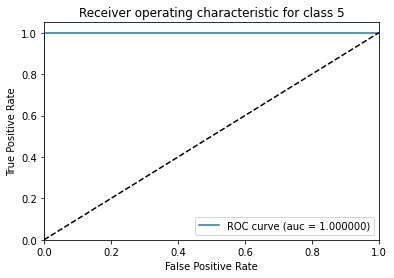

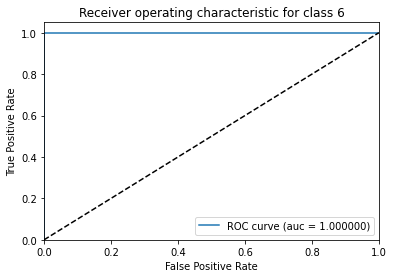

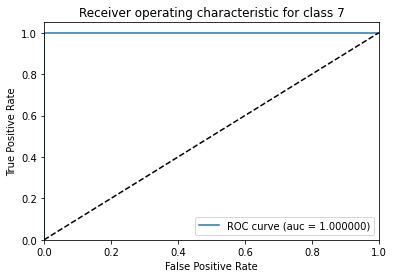

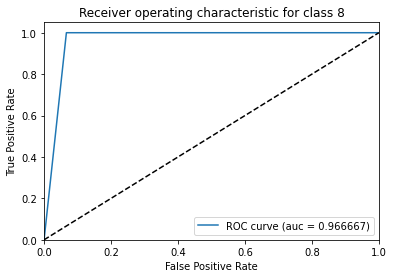

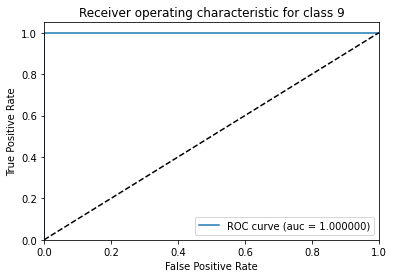



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


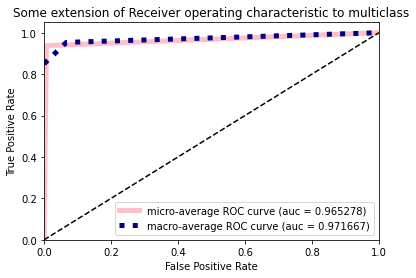

In [12]:
model7 = mlp_model("Sigmoid", "CrossEntropyLoss", "SGD", 10)

Sigmoid, CrossEntropyLoss, Adam

Activation function : Sigmoid
Loss function : CrossEntropyLoss
optimizer : Adam
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 1.0763
Epoch [1/10], Step [400/938], Loss: 0.4544
Epoch [1/10], Step [600/938], Loss: 0.3699
Epoch [1/10], Step [800/938], Loss: 0.3586
Epoch [2/10], Step [200/938], Loss: 0.2754
Epoch [2/10], Step [400/938], Loss: 0.2377
Epoch [2/10], Step [600/938], Loss: 0.2130
Epoch [2/10], Step [800/938], Loss: 0.2164
Epoch [3/10], Step [200/938], Loss: 0.1883
Epoch [3/10], Step [400/938], Loss: 0.1839
Epoch [3/10], Step [600/938], Loss: 0.1803
Epoch [3/10], Step [800/938], Loss: 0.1849
Epoch [4/10], Step [200/938], Loss: 0.1571
Epoch [4/10], Step [400/938], Loss: 0.1518
Epoch [4/10], Step [600/938], Loss: 0.1492
Epoch [4/10], Step [800/938], Loss: 0.1642
Epoch [5/10], Step [200/938], Loss: 0.1240
Epoch [5/10], Step [400/938], Loss: 0.1267
Epoch [5/10], Step [600

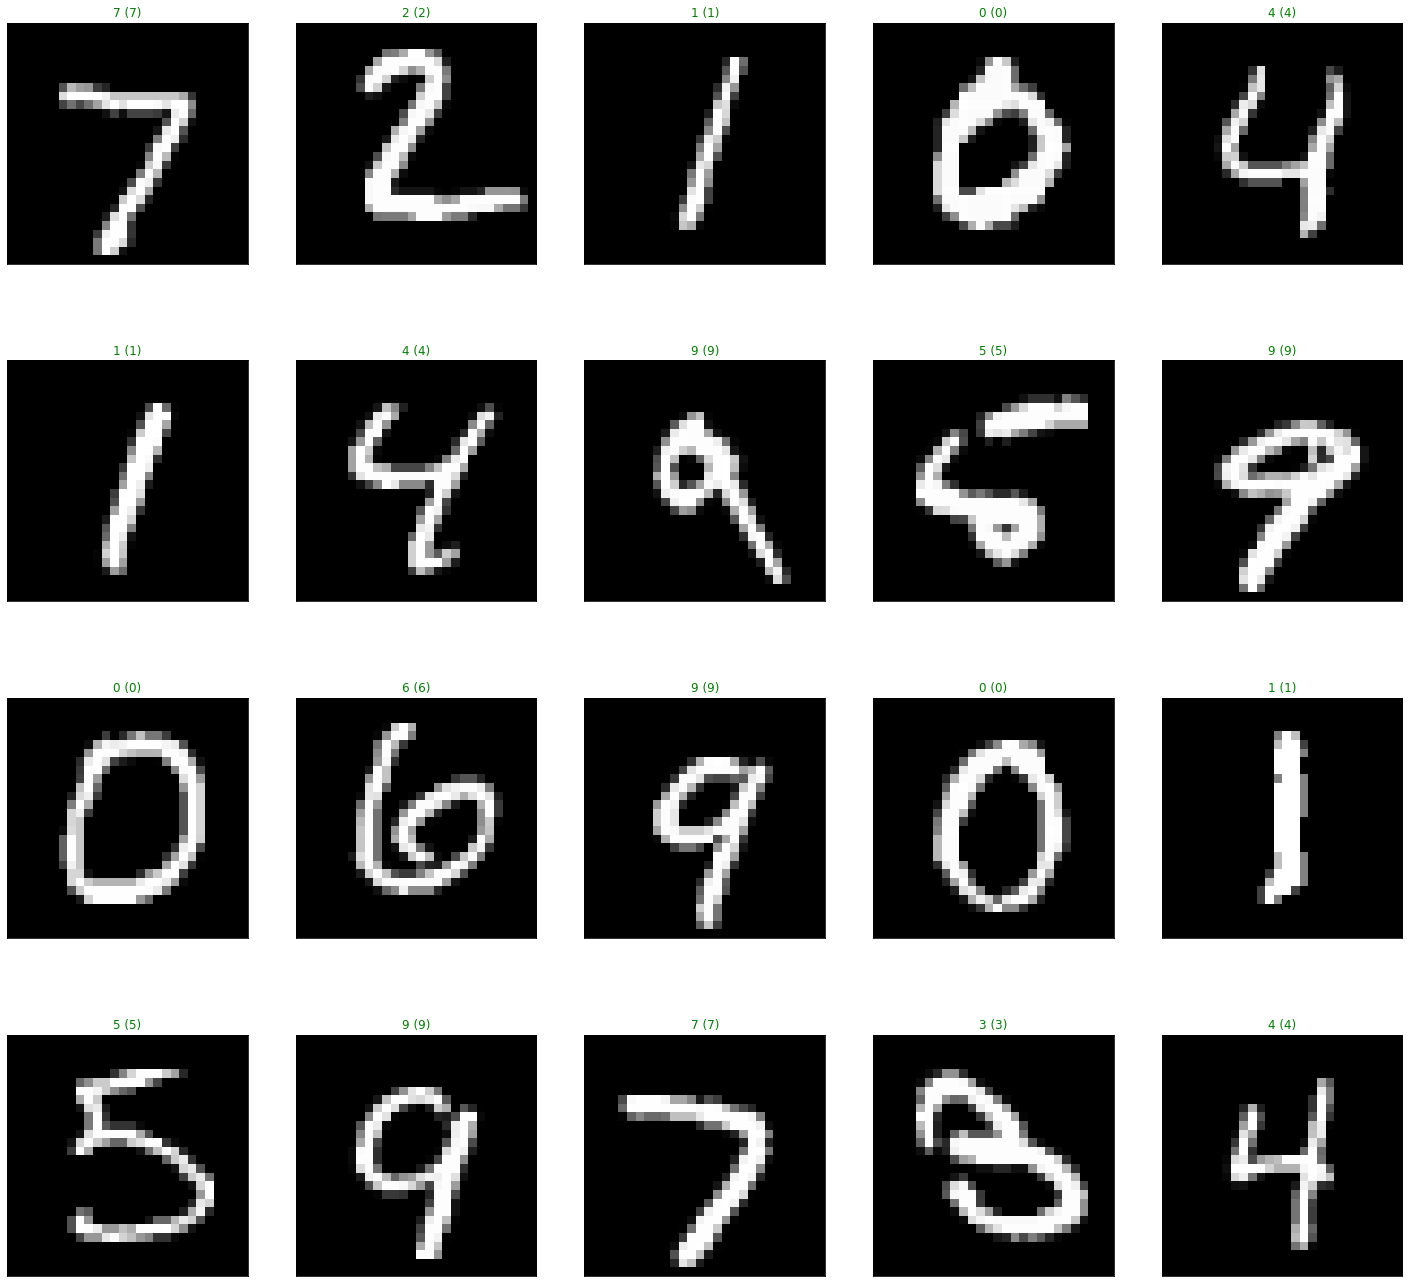

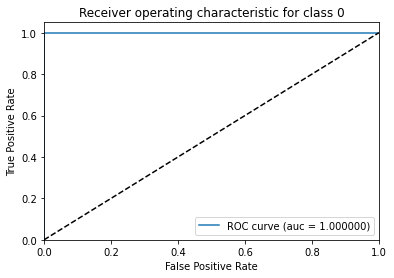

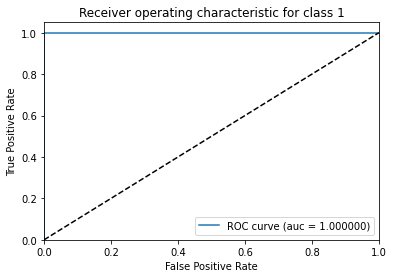

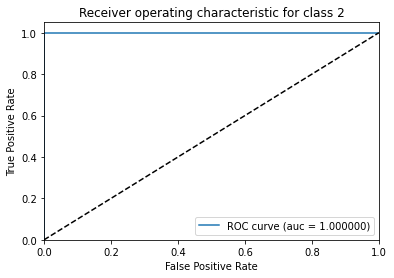

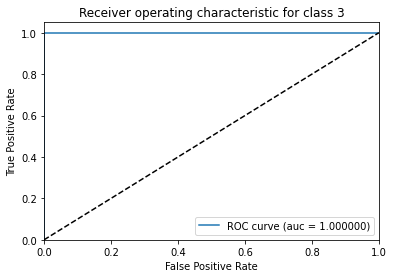

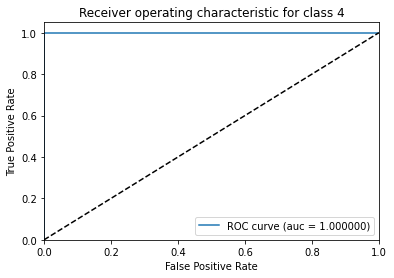

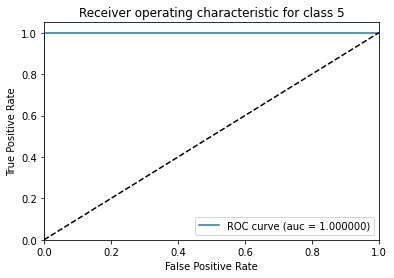

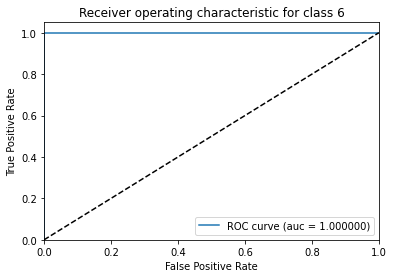

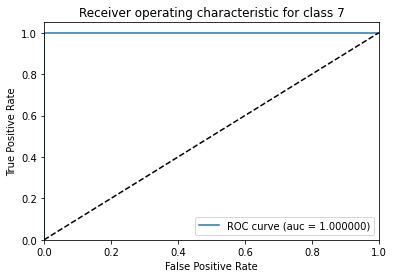

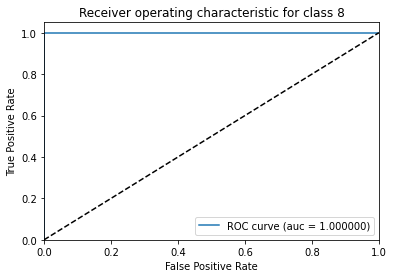

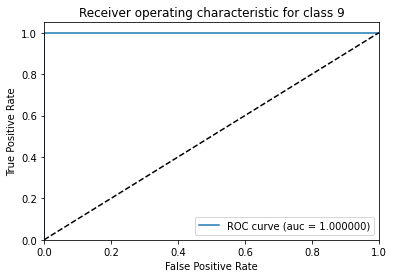



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


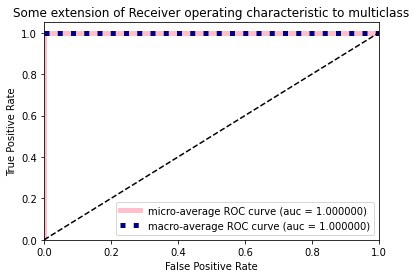

In [13]:
model8 = mlp_model("Sigmoid", "CrossEntropyLoss", "Adam", 10)

Sigmoid, CrossEntropyLoss, Adagrad

Activation function : Sigmoid
Loss function : CrossEntropyLoss
optimizer : Adagrad
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 1.7087
Epoch [1/10], Step [400/938], Loss: 0.8199
Epoch [1/10], Step [600/938], Loss: 0.6950
Epoch [1/10], Step [800/938], Loss: 0.6398
Epoch [2/10], Step [200/938], Loss: 0.5243
Epoch [2/10], Step [400/938], Loss: 0.5226
Epoch [2/10], Step [600/938], Loss: 0.5175
Epoch [2/10], Step [800/938], Loss: 0.5107
Epoch [3/10], Step [200/938], Loss: 0.4368
Epoch [3/10], Step [400/938], Loss: 0.4445
Epoch [3/10], Step [600/938], Loss: 0.4498
Epoch [3/10], Step [800/938], Loss: 0.4492
Epoch [4/10], Step [200/938], Loss: 0.3875
Epoch [4/10], Step [400/938], Loss: 0.3973
Epoch [4/10], Step [600/938], Loss: 0.4068
Epoch [4/10], Step [800/938], Loss: 0.4081
Epoch [5/10], Step [200/938], Loss: 0.3532
Epoch [5/10], Step [400/938], Loss: 0.3633
Epoch [5/10], Step [

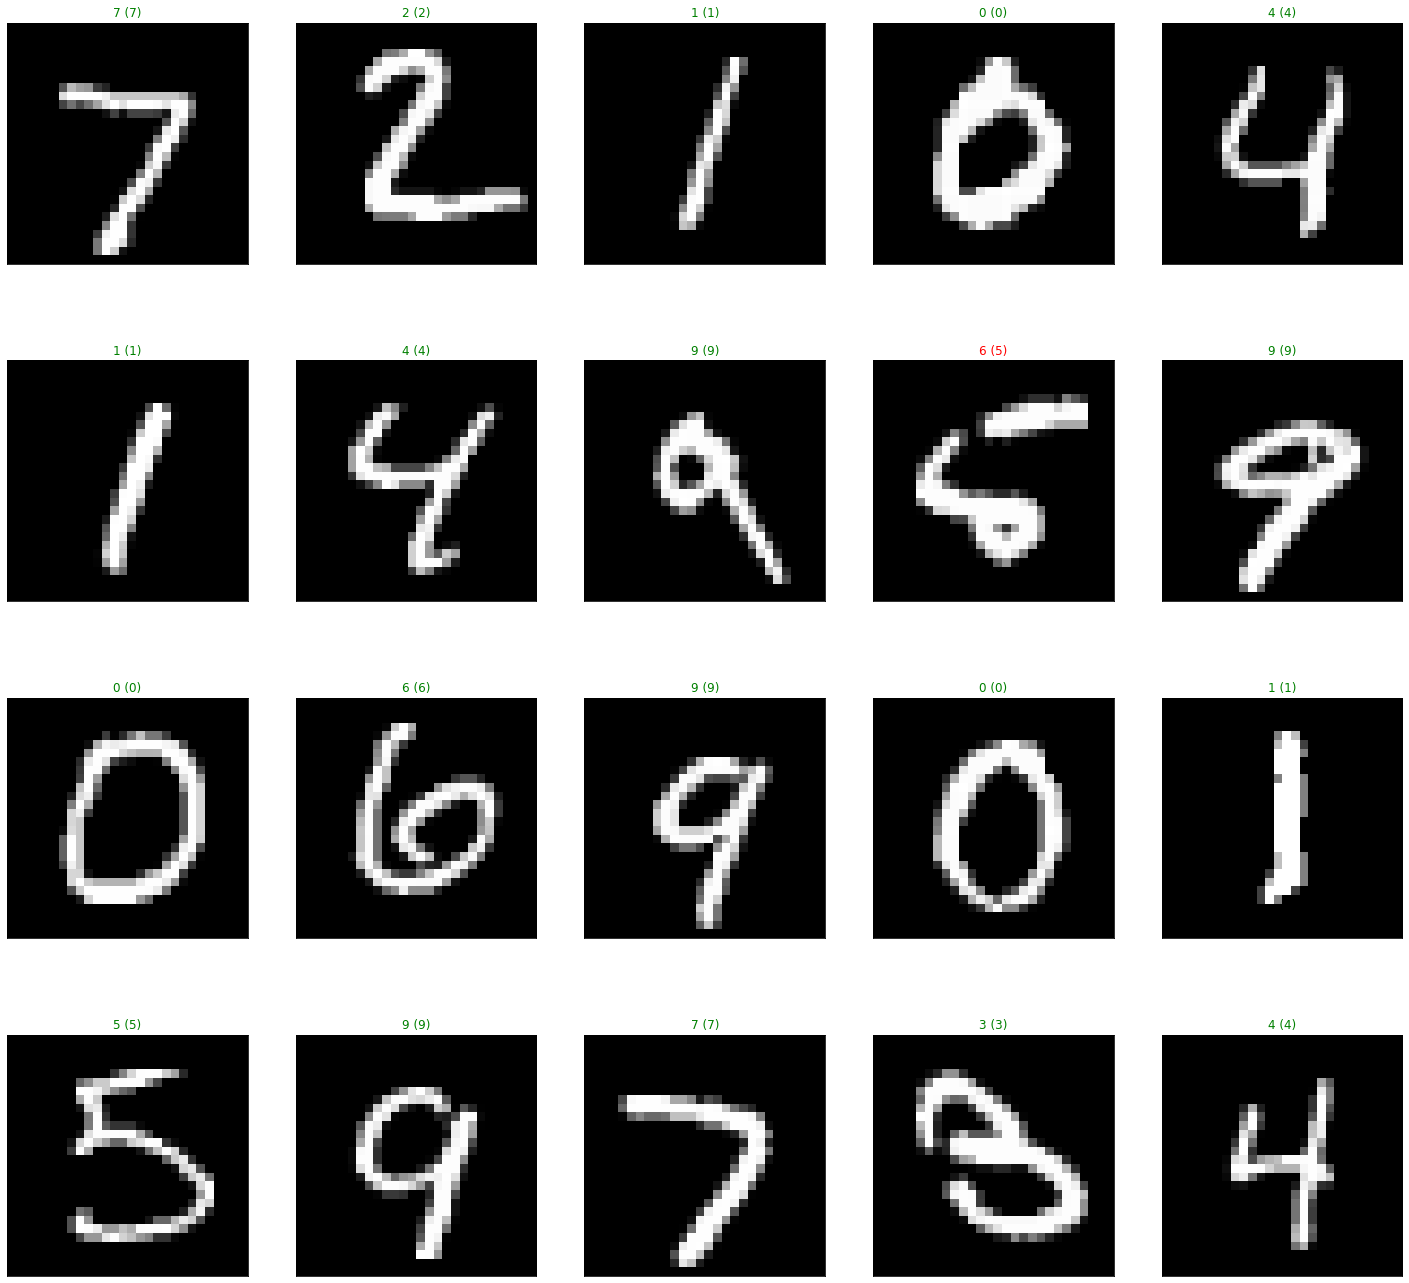

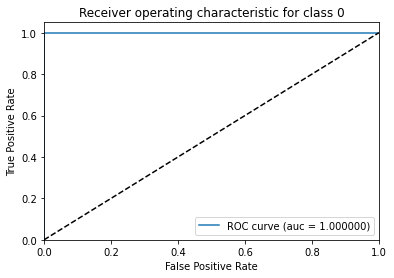

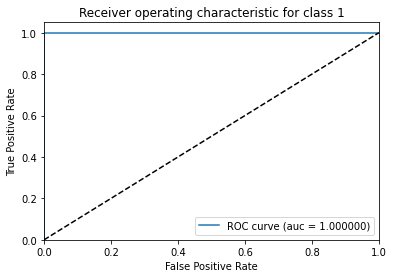

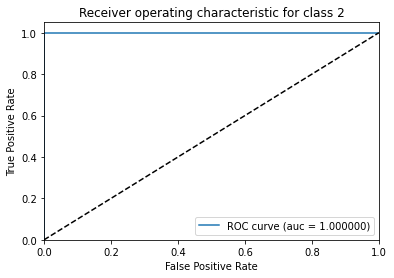

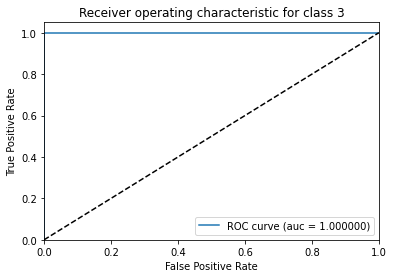

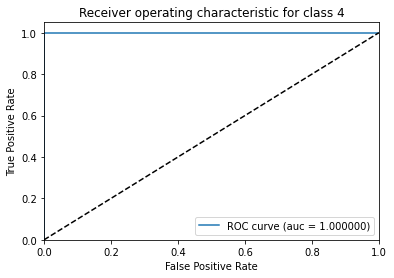

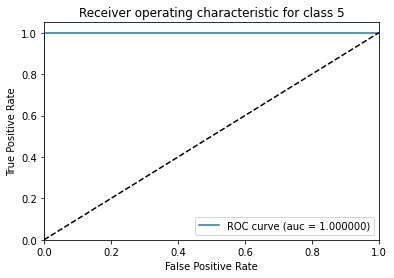

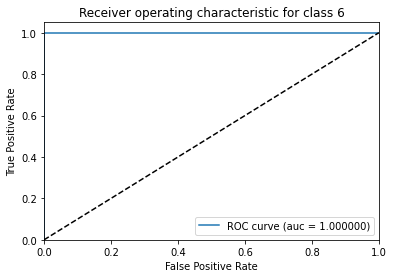

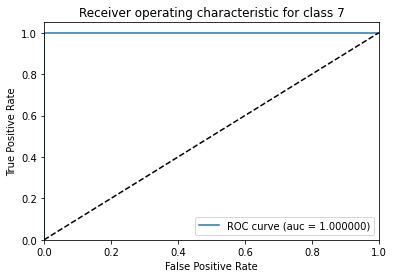

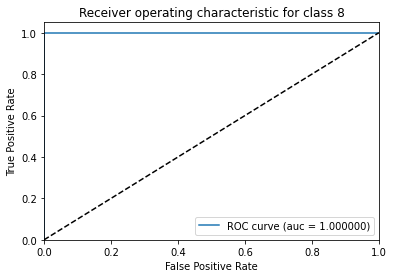

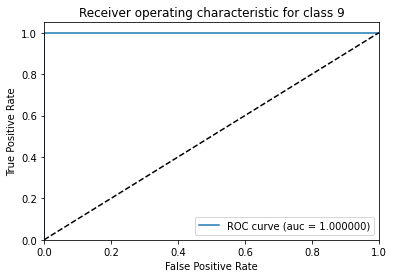



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


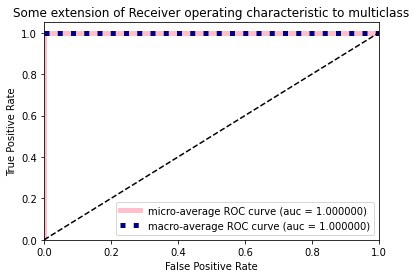

In [14]:
model9 = mlp_model("Sigmoid", "CrossEntropyLoss", "Adagrad", 10)

Sigmoid, NLLLoss, SGD

Activation function : Sigmoid
Loss function : NLLLoss
optimizer : SGD
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -199.3842
Epoch [1/10], Step [400/938], Loss: -711.1917
Epoch [1/10], Step [600/938], Loss: -1228.3232
Epoch [1/10], Step [800/938], Loss: -1745.8855
Epoch [2/10], Step [200/938], Loss: -2621.6476
Epoch [2/10], Step [400/938], Loss: -3138.7497
Epoch [2/10], Step [600/938], Loss: -3654.8609
Epoch [2/10], Step [800/938], Loss: -4172.9364
Epoch [3/10], Step [200/938], Loss: -5049.8091
Epoch [3/10], Step [400/938], Loss: -5566.3085
Epoch [3/10], Step [600/938], Loss: -6081.3962
Epoch [3/10], Step [800/938], Loss: -6599.9852
Epoch [4/10], Step [200/938], Loss: -7477.9696
Epoch [4/10], Step [400/938], Loss: -7993.8661
Epoch [4/10], Step [600/938], Loss: -8507.9313
Epoch [4/10], Step [800/938], Loss: -9027.0342
Epoch [5/10], Step [200/938], Loss: -9906.1293
Epoch [5/1

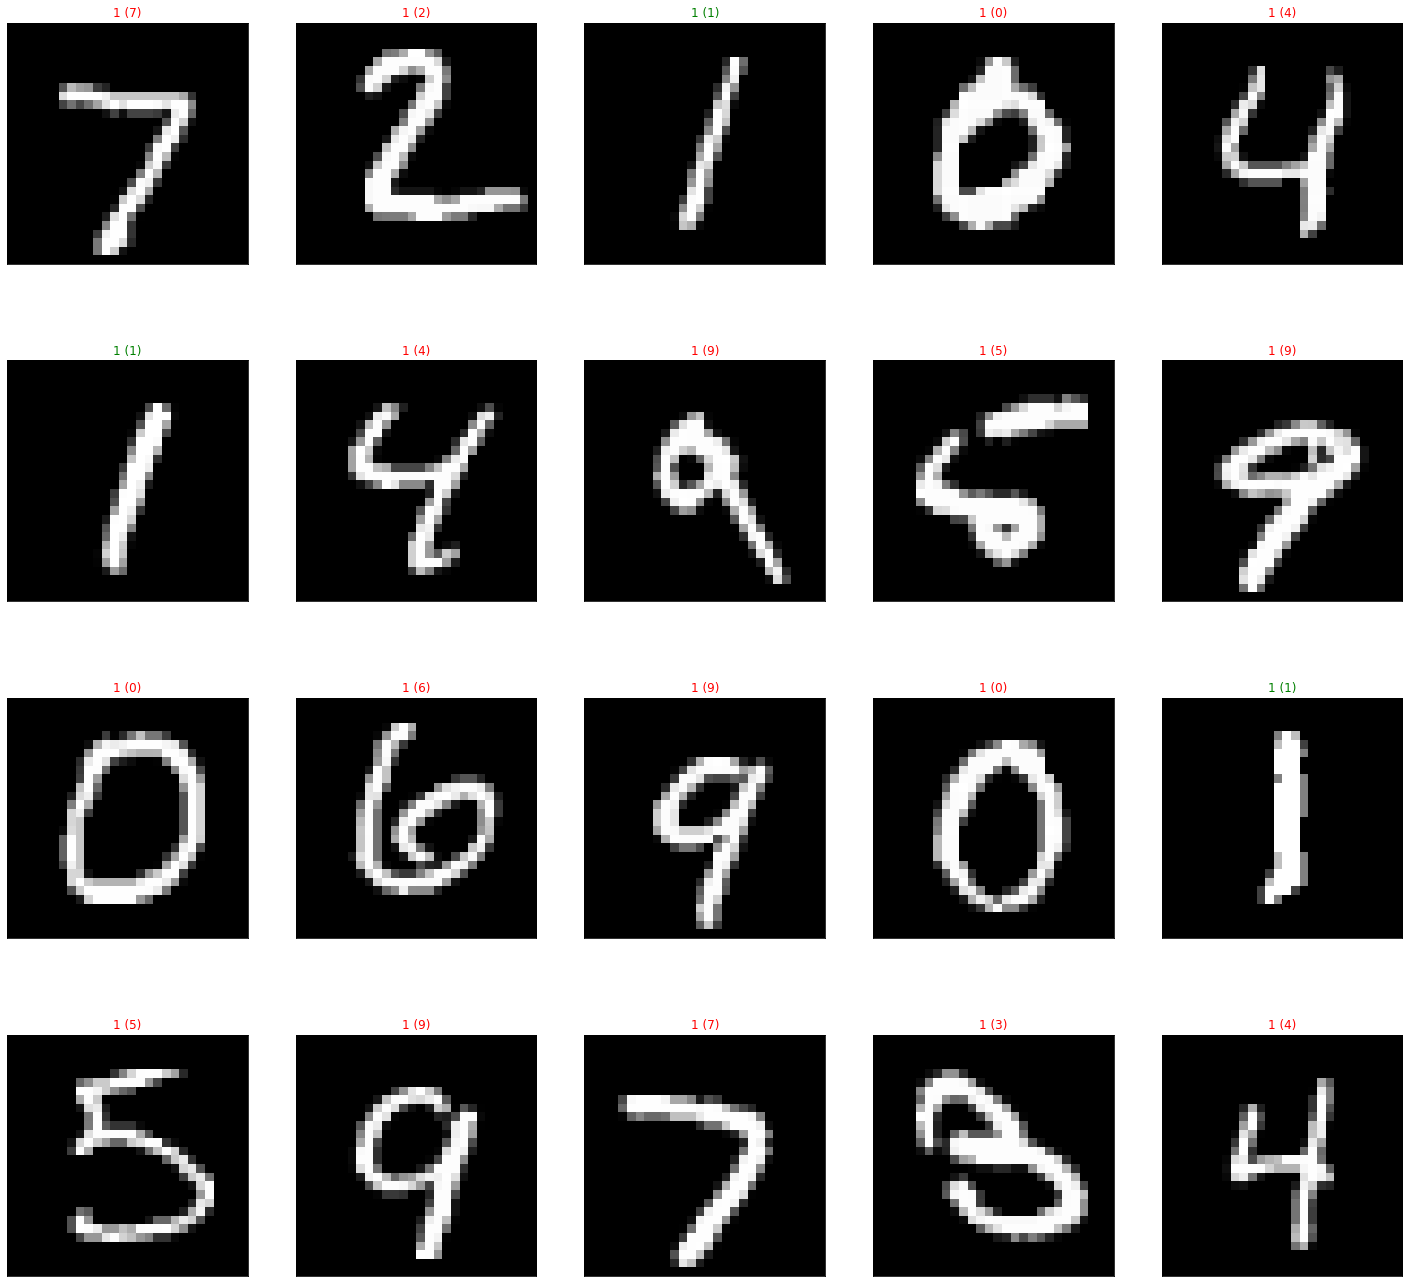

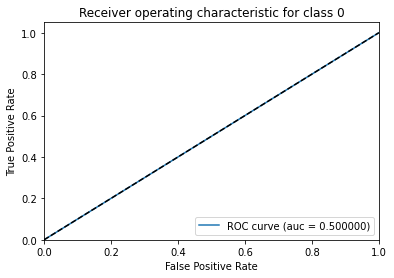

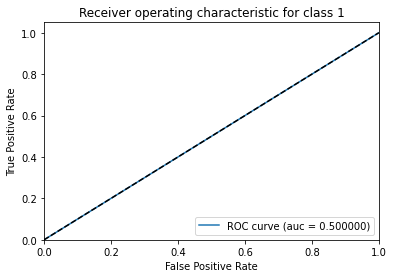

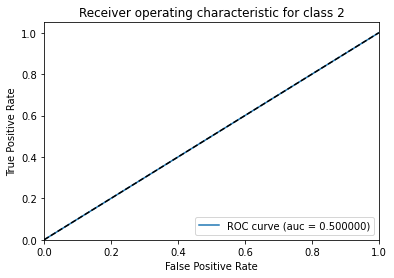

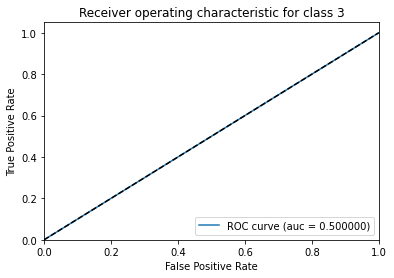

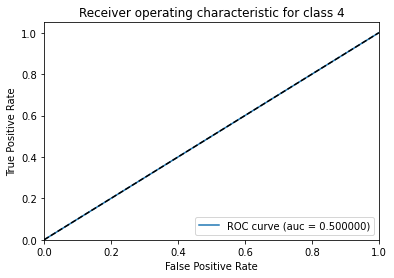

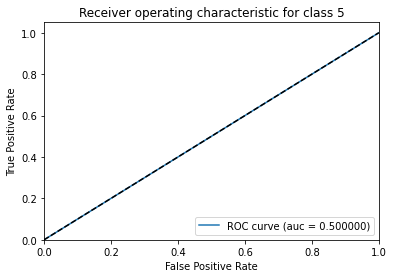

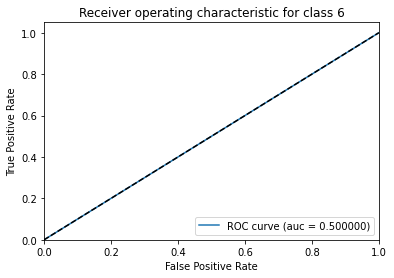

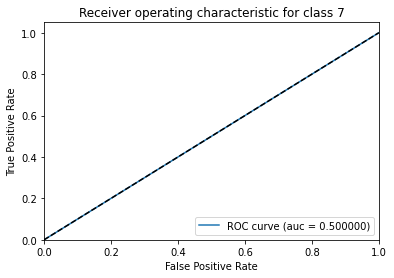

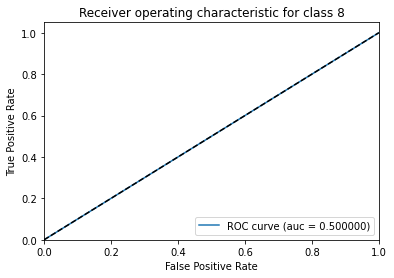

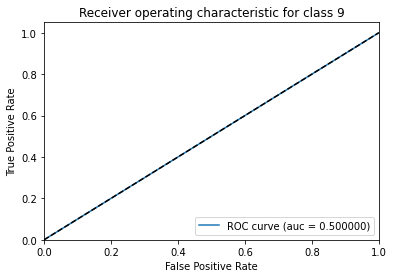



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


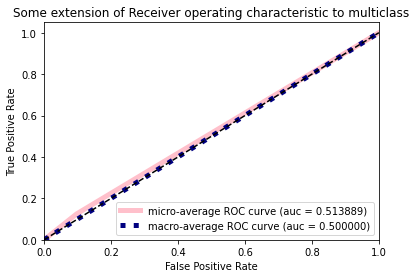

In [15]:
model10 = mlp_model("Sigmoid", "NLLLoss", "SGD", 10)

Sigmoid, NLLLoss, Adam

Activation function : Sigmoid
Loss function : NLLLoss
optimizer : Adam
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -218.1457
Epoch [1/10], Step [400/938], Loss: -721.2263
Epoch [1/10], Step [600/938], Loss: -1237.3025
Epoch [1/10], Step [800/938], Loss: -1739.8728
Epoch [2/10], Step [200/938], Loss: -2578.6088
Epoch [2/10], Step [400/938], Loss: -3072.1077
Epoch [2/10], Step [600/938], Loss: -3564.2855
Epoch [2/10], Step [800/938], Loss: -4055.8477
Epoch [3/10], Step [200/938], Loss: -4885.5861
Epoch [3/10], Step [400/938], Loss: -5376.0156
Epoch [3/10], Step [600/938], Loss: -5865.9987
Epoch [3/10], Step [800/938], Loss: -6355.9051
Epoch [4/10], Step [200/938], Loss: -7183.8732
Epoch [4/10], Step [400/938], Loss: -7673.4749
Epoch [4/10], Step [600/938], Loss: -8162.7947
Epoch [4/10], Step [800/938], Loss: -8652.1551
Epoch [5/10], Step [200/938], Loss: -9479.6502
Epoch [5/

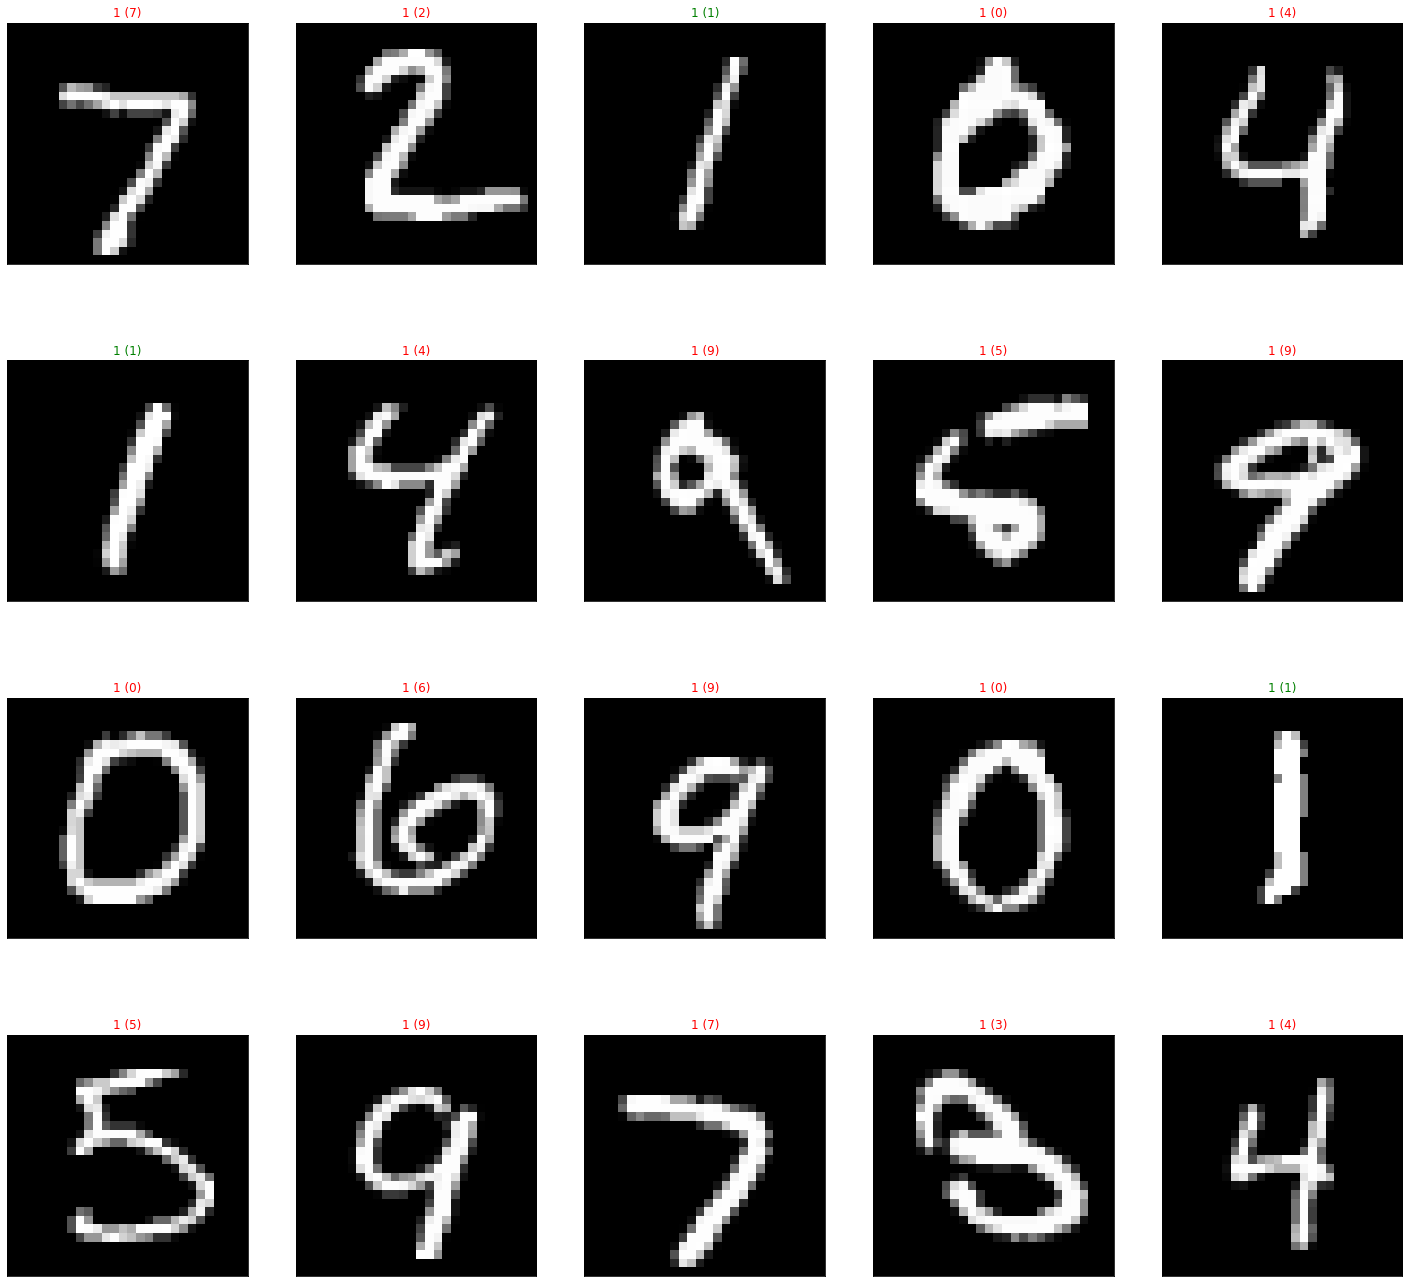

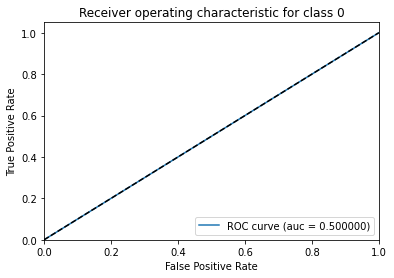

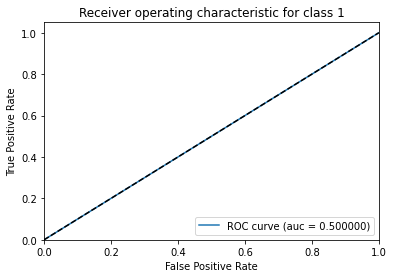

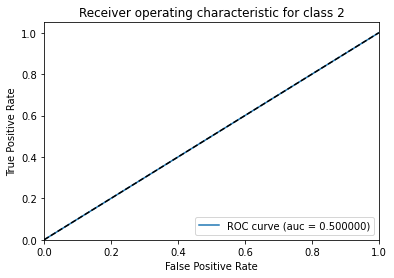

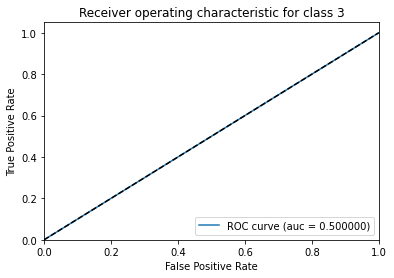

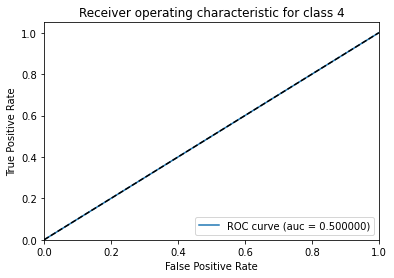

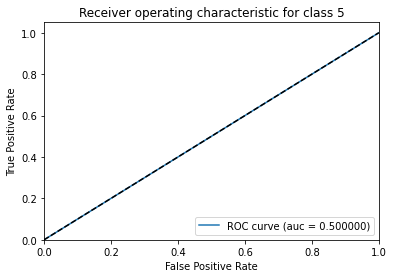

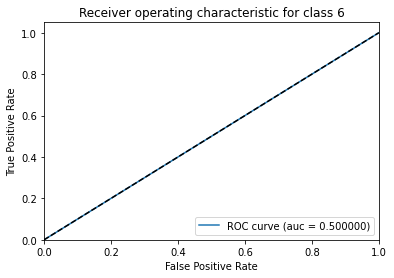

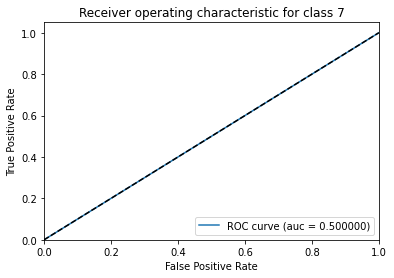

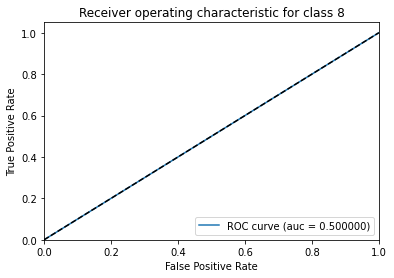

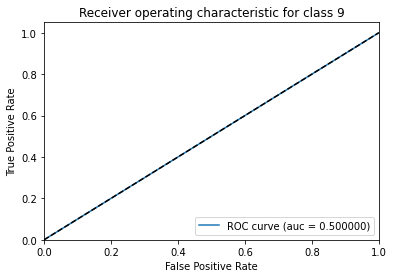



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


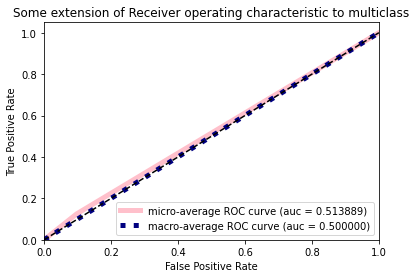

In [16]:
model11 = mlp_model("Sigmoid", "NLLLoss", "Adam", 10)

Sigmoid, NLLLoss, Adagrad

Activation function : Sigmoid
Loss function : NLLLoss
optimizer : Adagrad
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -44.8037
Epoch [1/10], Step [400/938], Loss: -83.0794
Epoch [1/10], Step [600/938], Loss: -107.9293
Epoch [1/10], Step [800/938], Loss: -127.9452
Epoch [2/10], Step [200/938], Loss: -156.0143
Epoch [2/10], Step [400/938], Loss: -170.8018
Epoch [2/10], Step [600/938], Loss: -184.3459
Epoch [2/10], Step [800/938], Loss: -197.3007
Epoch [3/10], Step [200/938], Loss: -217.1025
Epoch [3/10], Step [400/938], Loss: -227.9773
Epoch [3/10], Step [600/938], Loss: -238.3290
Epoch [3/10], Step [800/938], Loss: -248.2665
Epoch [4/10], Step [200/938], Loss: -264.1547
Epoch [4/10], Step [400/938], Loss: -273.1278
Epoch [4/10], Step [600/938], Loss: -281.7989
Epoch [4/10], Step [800/938], Loss: -290.2355
Epoch [5/10], Step [200/938], Loss: -303.9143
Epoch [5/10], Step [400

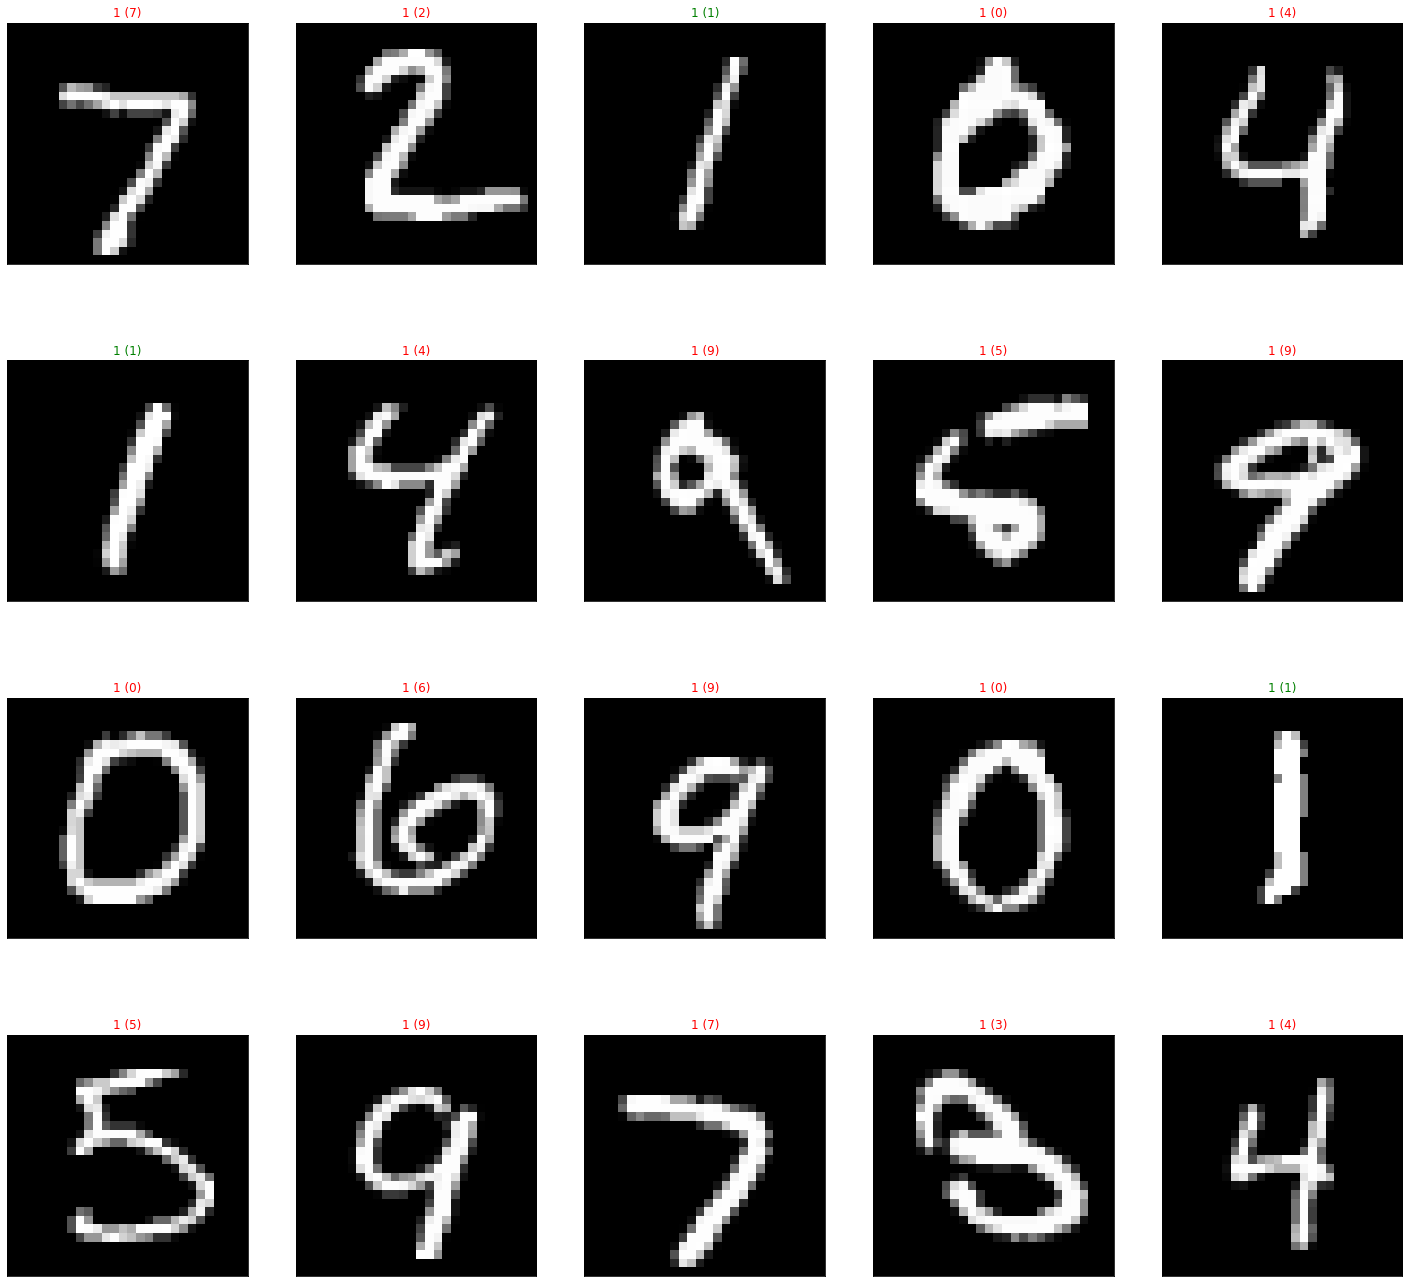

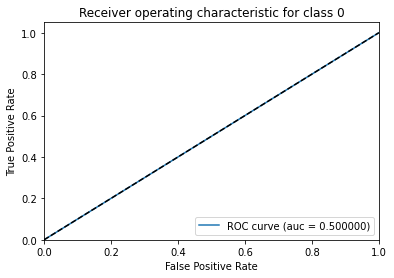

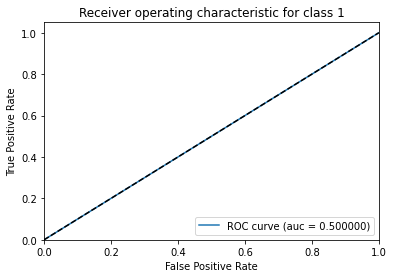

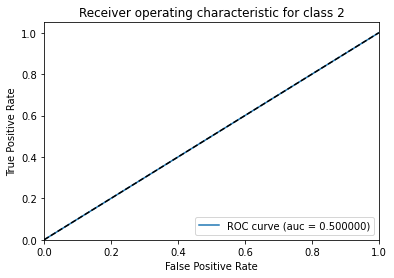

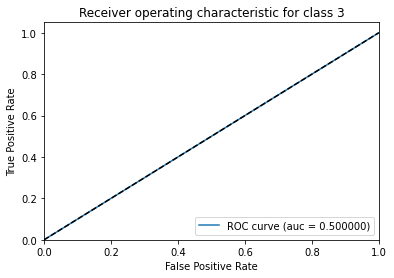

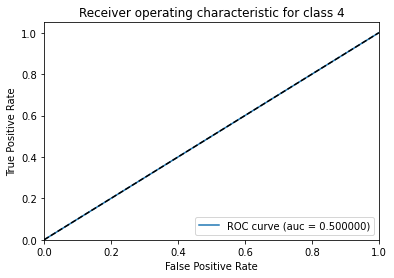

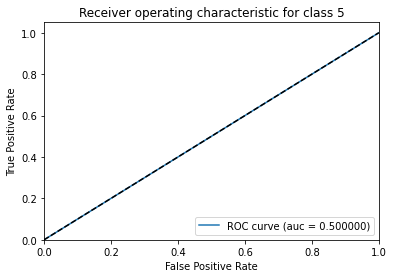

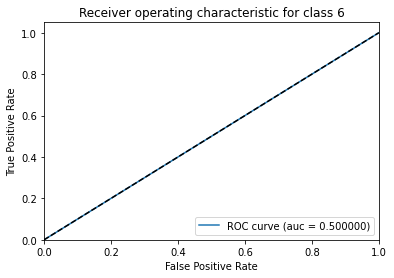

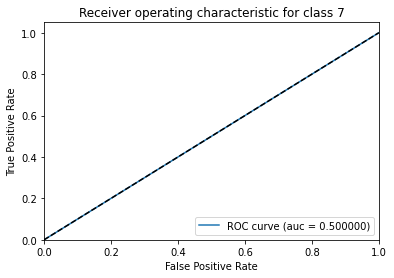

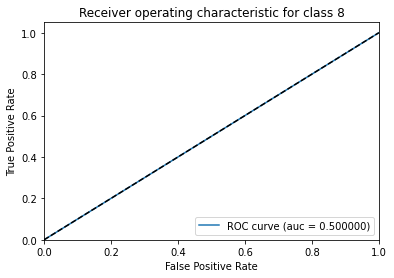

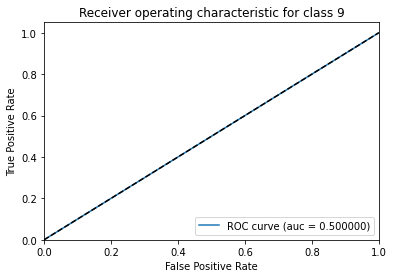



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


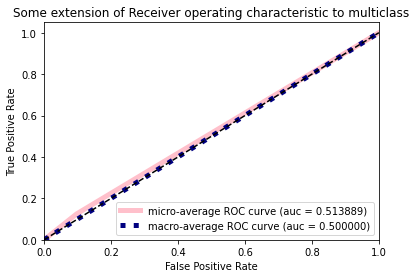

In [17]:
model12 = mlp_model("Sigmoid", "NLLLoss", "Adagrad", 10)

Tanh, CrossEntropyLoss, SGD

Activation function : Tanh
Loss function : CrossEntropyLoss
optimizer : SGD
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 1.9740
Epoch [1/10], Step [400/938], Loss: 0.7856
Epoch [1/10], Step [600/938], Loss: 0.6953
Epoch [1/10], Step [800/938], Loss: 0.6677
Epoch [2/10], Step [200/938], Loss: 0.5345
Epoch [2/10], Step [400/938], Loss: 0.5138
Epoch [2/10], Step [600/938], Loss: 0.5113
Epoch [2/10], Step [800/938], Loss: 0.5139
Epoch [3/10], Step [200/938], Loss: 0.4020
Epoch [3/10], Step [400/938], Loss: 0.3887
Epoch [3/10], Step [600/938], Loss: 0.3928
Epoch [3/10], Step [800/938], Loss: 0.4008
Epoch [4/10], Step [200/938], Loss: 0.3121
Epoch [4/10], Step [400/938], Loss: 0.3083
Epoch [4/10], Step [600/938], Loss: 0.3142
Epoch [4/10], Step [800/938], Loss: 0.3230
Epoch [5/10], Step [200/938], Loss: 0.2522
Epoch [5/10], Step [400/938], Loss: 0.2527
Epoch [5/10], Step [600/938

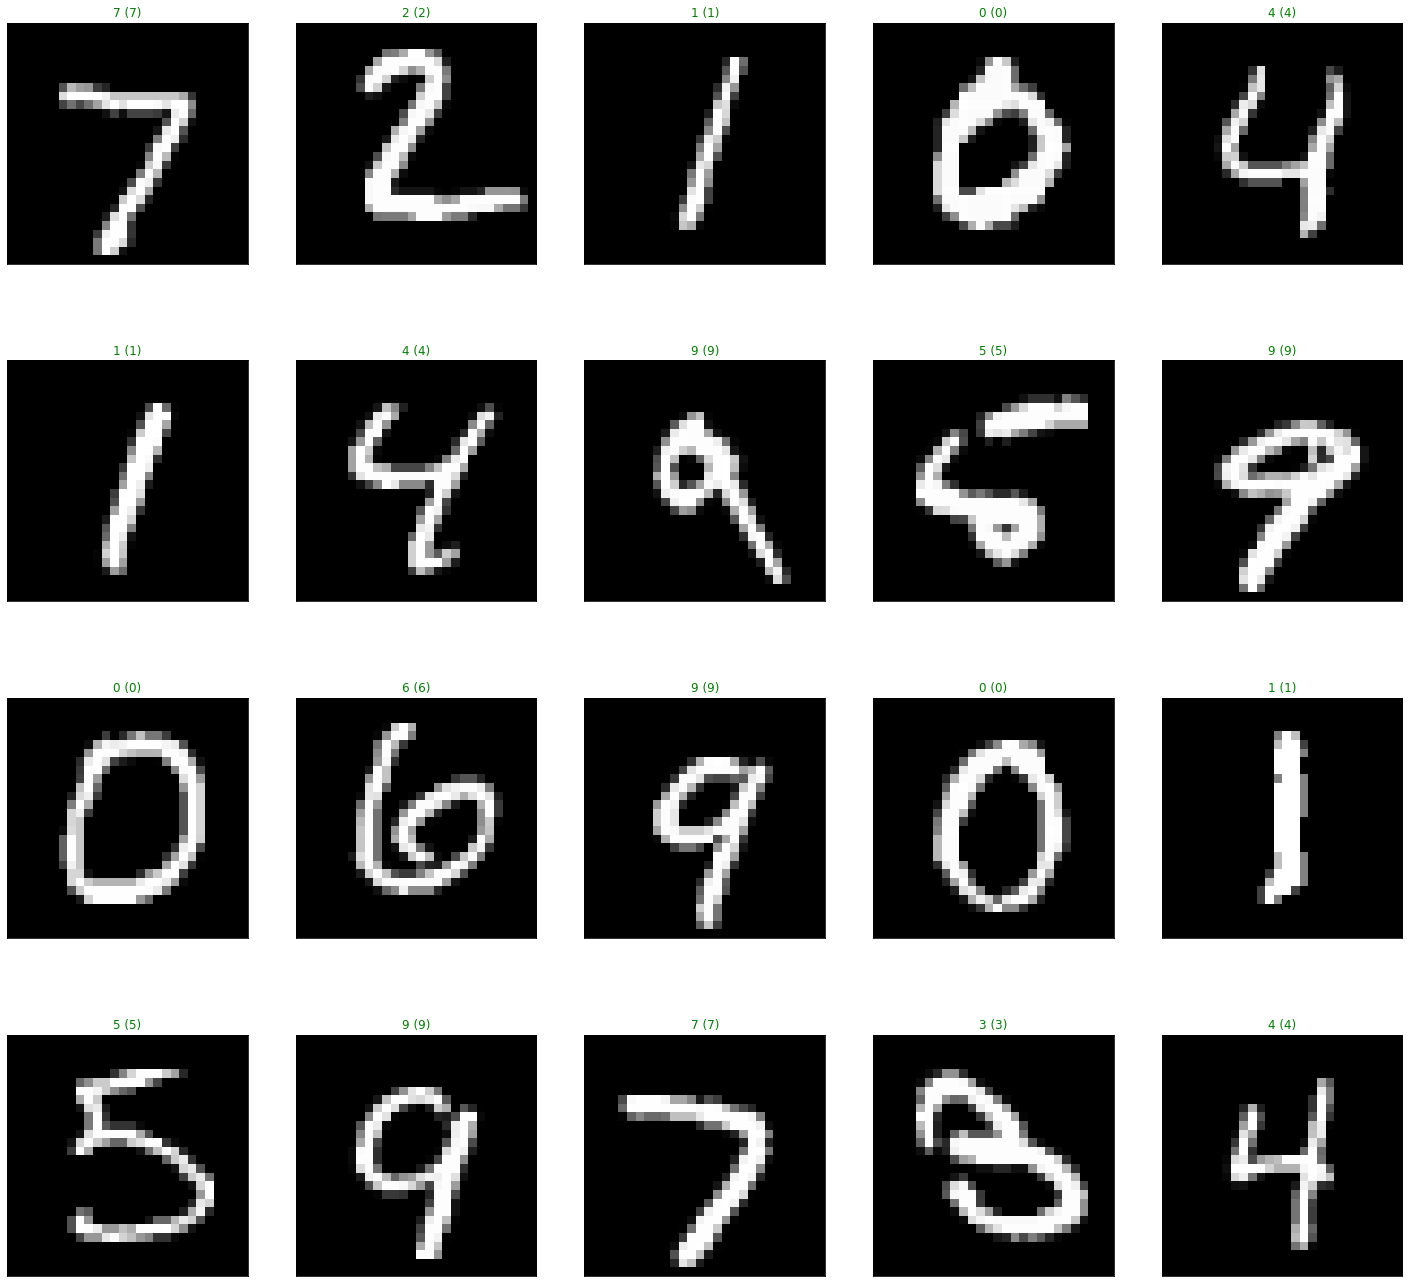

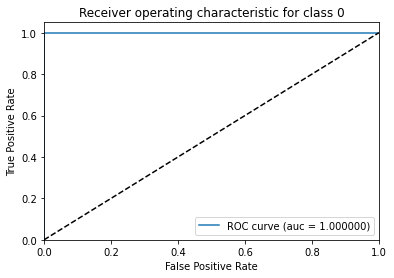

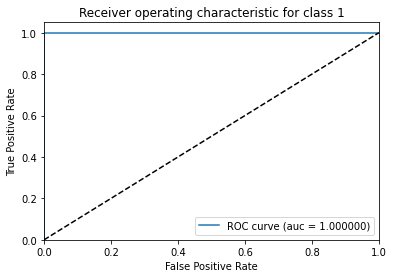

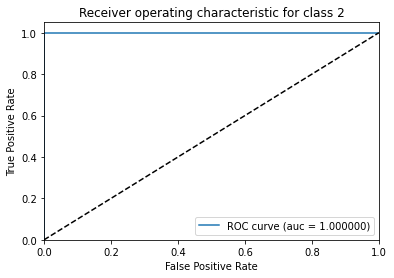

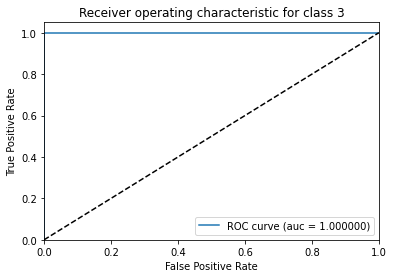

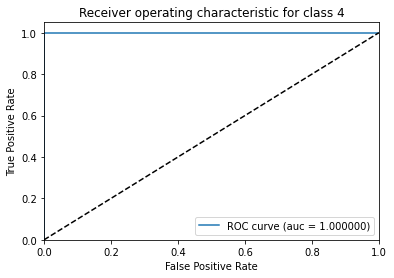

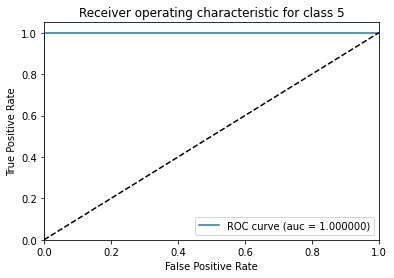

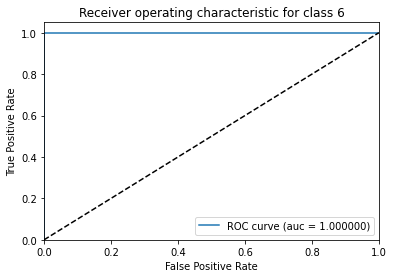

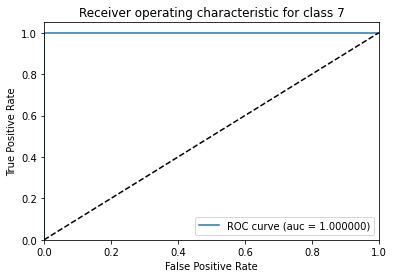

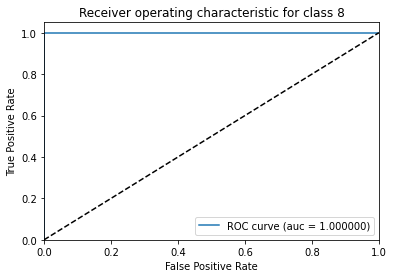

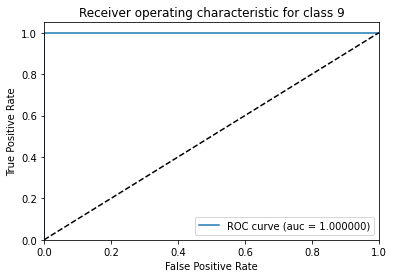



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


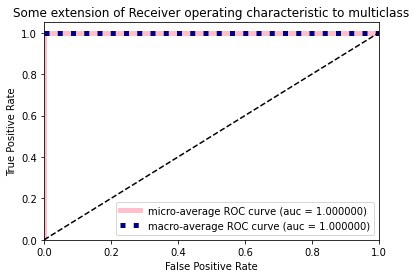

In [18]:
model13 = mlp_model("Tanh", "CrossEntropyLoss", "SGD", 10)

Tanh, CrossEntropyLoss, Adam

Activation function : Tanh
Loss function : CrossEntropyLoss
optimizer : Adam
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 0.9036
Epoch [1/10], Step [400/938], Loss: 0.5995
Epoch [1/10], Step [600/938], Loss: 0.5858
Epoch [1/10], Step [800/938], Loss: 0.5705
Epoch [2/10], Step [200/938], Loss: 0.4986
Epoch [2/10], Step [400/938], Loss: 0.4956
Epoch [2/10], Step [600/938], Loss: 0.5214
Epoch [2/10], Step [800/938], Loss: 0.5472
Epoch [3/10], Step [200/938], Loss: 0.5265
Epoch [3/10], Step [400/938], Loss: 0.5387
Epoch [3/10], Step [600/938], Loss: 0.5220
Epoch [3/10], Step [800/938], Loss: 0.5160
Epoch [4/10], Step [200/938], Loss: 0.4538
Epoch [4/10], Step [400/938], Loss: 0.4864
Epoch [4/10], Step [600/938], Loss: 0.5134
Epoch [4/10], Step [800/938], Loss: 0.5097
Epoch [5/10], Step [200/938], Loss: 0.4802
Epoch [5/10], Step [400/938], Loss: 0.5144
Epoch [5/10], Step [600/93

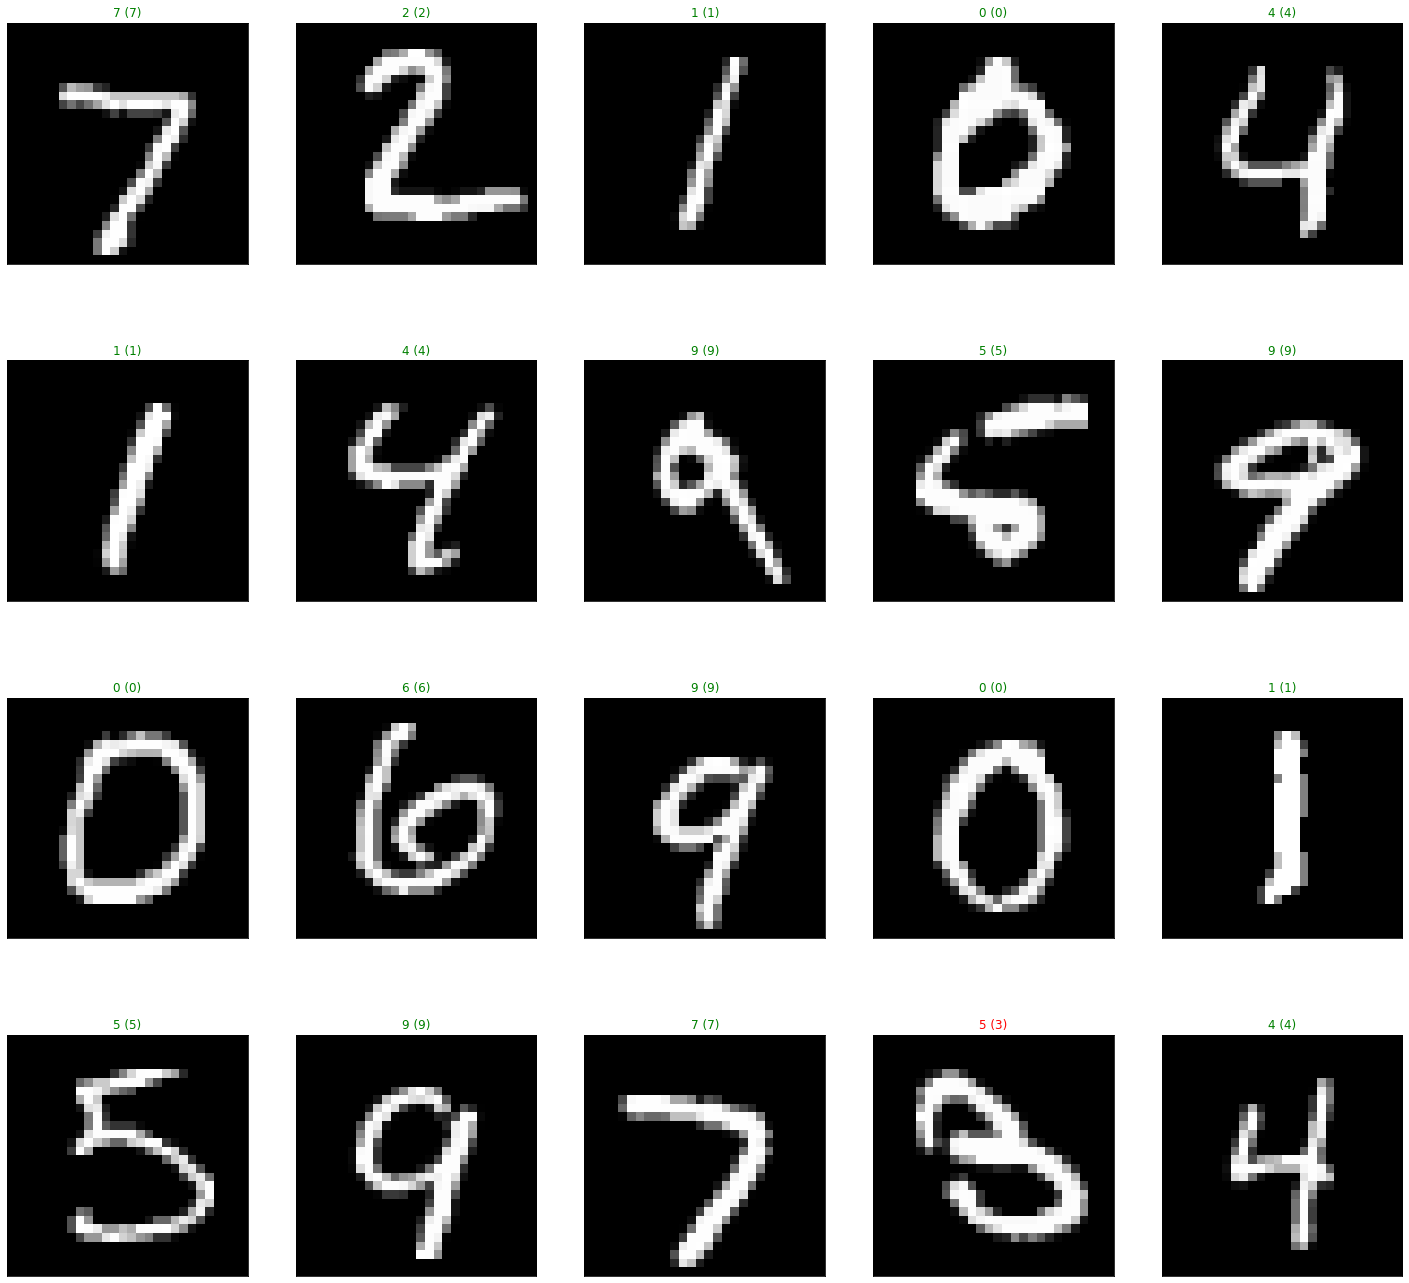

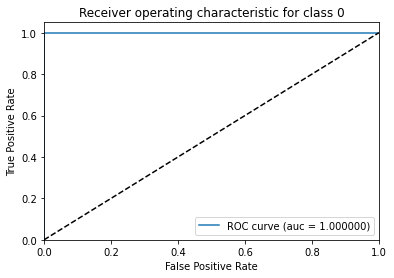

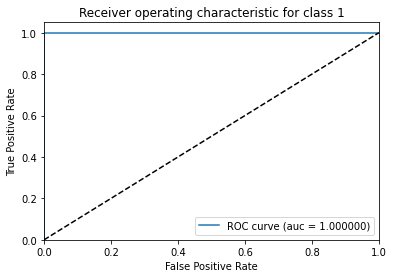

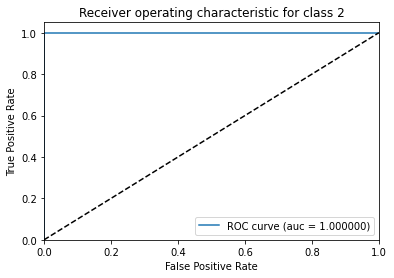

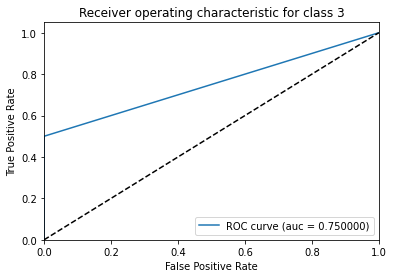

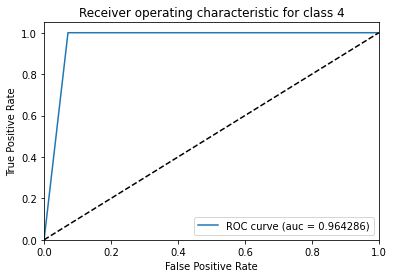

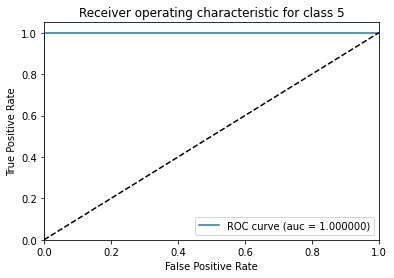

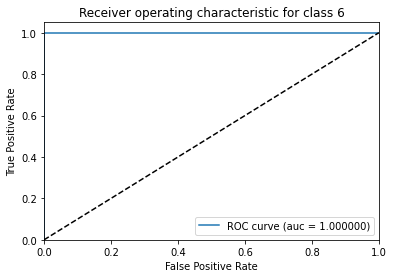

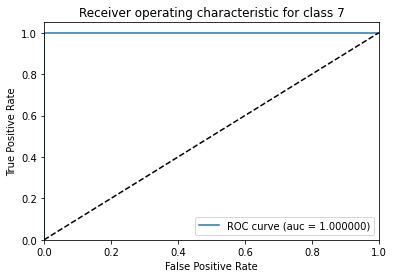

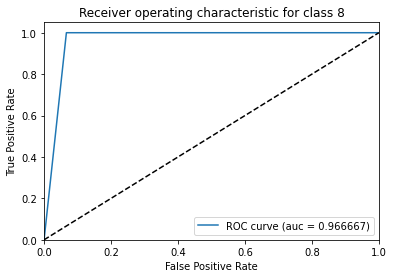

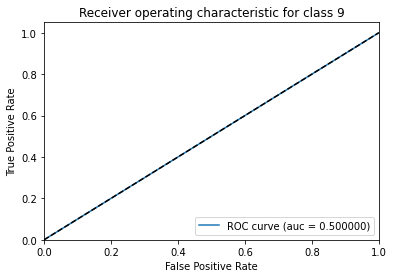



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


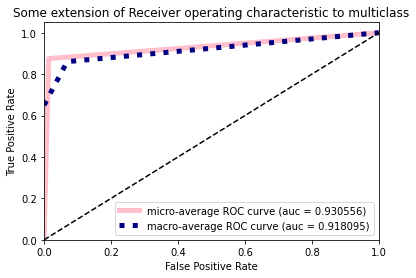

In [19]:
model14 = mlp_model("Tanh", "CrossEntropyLoss", "Adam", 10)

Tanh, CrossEntropyLoss, Adagrad

Activation function : Tanh
Loss function : CrossEntropyLoss
optimizer : Adagrad
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: 0.8484
Epoch [1/10], Step [400/938], Loss: 0.5459
Epoch [1/10], Step [600/938], Loss: 0.4893
Epoch [1/10], Step [800/938], Loss: 0.4599
Epoch [2/10], Step [200/938], Loss: 0.3355
Epoch [2/10], Step [400/938], Loss: 0.3385
Epoch [2/10], Step [600/938], Loss: 0.3405
Epoch [2/10], Step [800/938], Loss: 0.3426
Epoch [3/10], Step [200/938], Loss: 0.2604
Epoch [3/10], Step [400/938], Loss: 0.2675
Epoch [3/10], Step [600/938], Loss: 0.2752
Epoch [3/10], Step [800/938], Loss: 0.2836
Epoch [4/10], Step [200/938], Loss: 0.2181
Epoch [4/10], Step [400/938], Loss: 0.2251
Epoch [4/10], Step [600/938], Loss: 0.2346
Epoch [4/10], Step [800/938], Loss: 0.2446
Epoch [5/10], Step [200/938], Loss: 0.1890
Epoch [5/10], Step [400/938], Loss: 0.1954
Epoch [5/10], Step [600

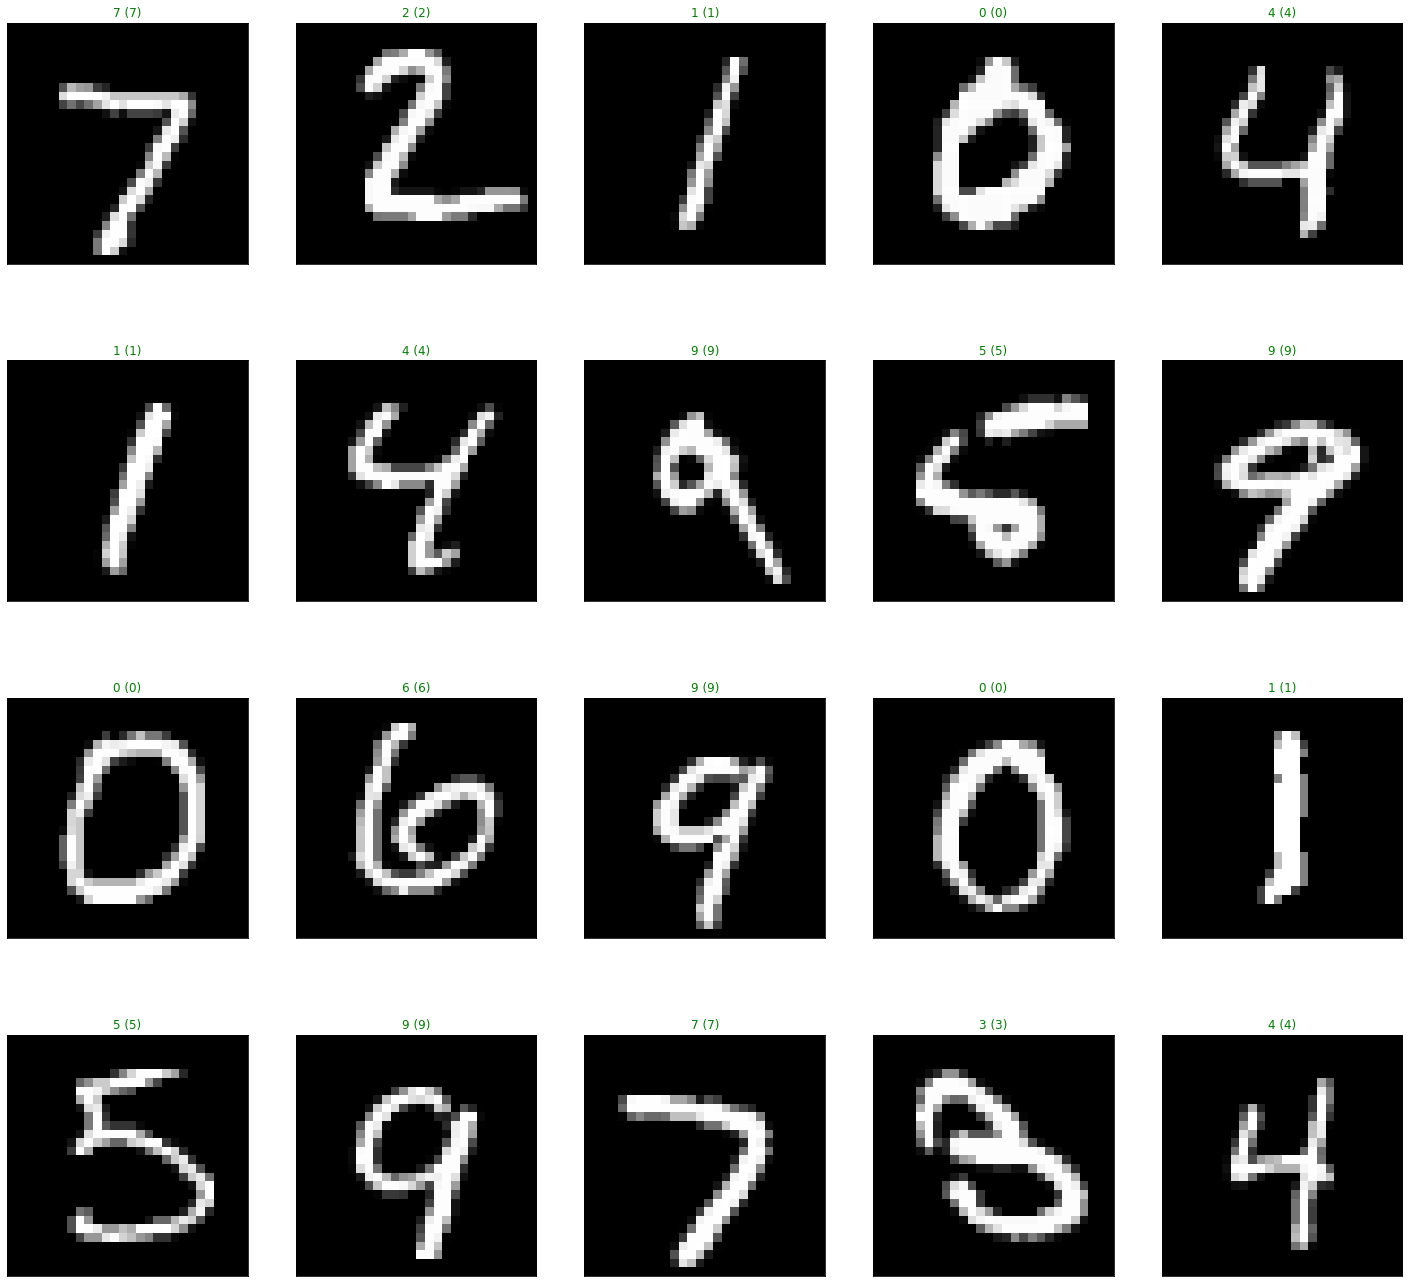

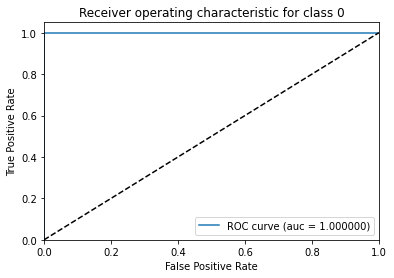

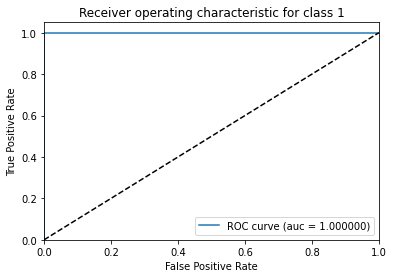

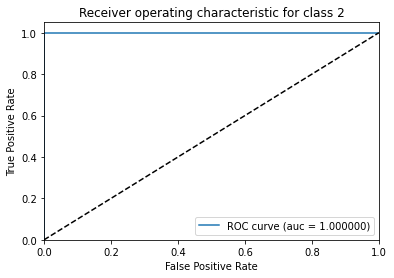

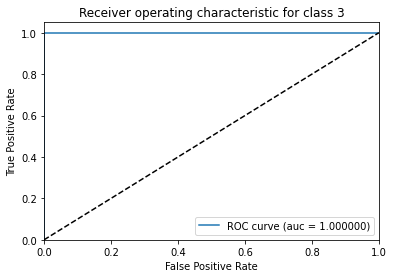

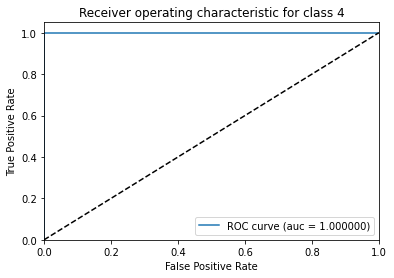

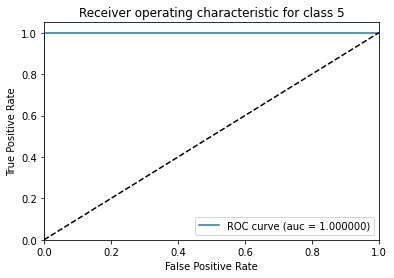

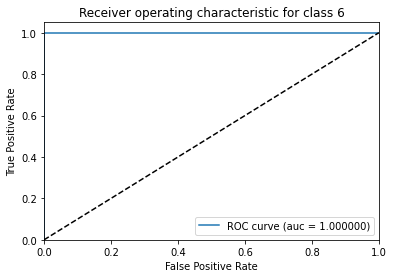

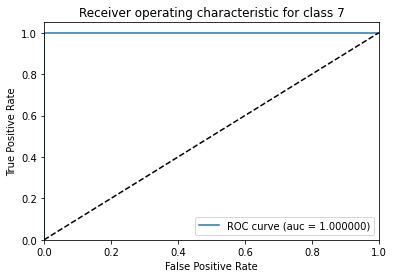

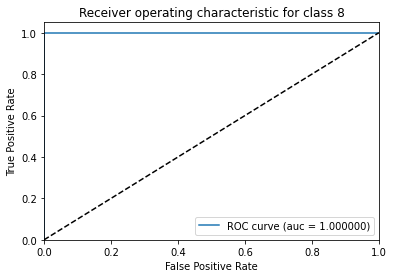

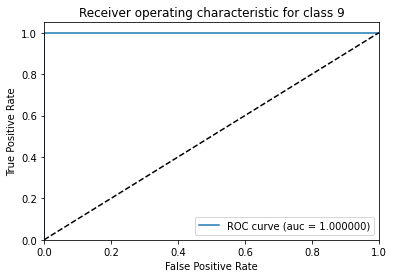



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


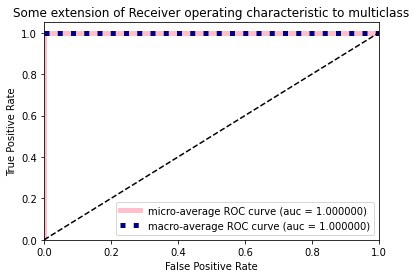

In [20]:
model15 = mlp_model("Tanh", "CrossEntropyLoss", "Adagrad", 10)

Tanh, NLLLoss, SGD

Activation function : Tanh
Loss function : NLLLoss
optimizer : SGD
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -182.4839
Epoch [1/10], Step [400/938], Loss: -691.7151
Epoch [1/10], Step [600/938], Loss: -1208.8763
Epoch [1/10], Step [800/938], Loss: -1726.4218
Epoch [2/10], Step [200/938], Loss: -2602.1564
Epoch [2/10], Step [400/938], Loss: -3119.2745
Epoch [2/10], Step [600/938], Loss: -3635.4134
Epoch [2/10], Step [800/938], Loss: -4153.4723
Epoch [3/10], Step [200/938], Loss: -5030.3182
Epoch [3/10], Step [400/938], Loss: -5546.8333
Epoch [3/10], Step [600/938], Loss: -6061.9481
Epoch [3/10], Step [800/938], Loss: -6580.5206
Epoch [4/10], Step [200/938], Loss: -7458.4781
Epoch [4/10], Step [400/938], Loss: -7974.3906
Epoch [4/10], Step [600/938], Loss: -8488.4827
Epoch [4/10], Step [800/938], Loss: -9007.5692
Epoch [5/10], Step [200/938], Loss: -9886.6377
Epoch [5/10],

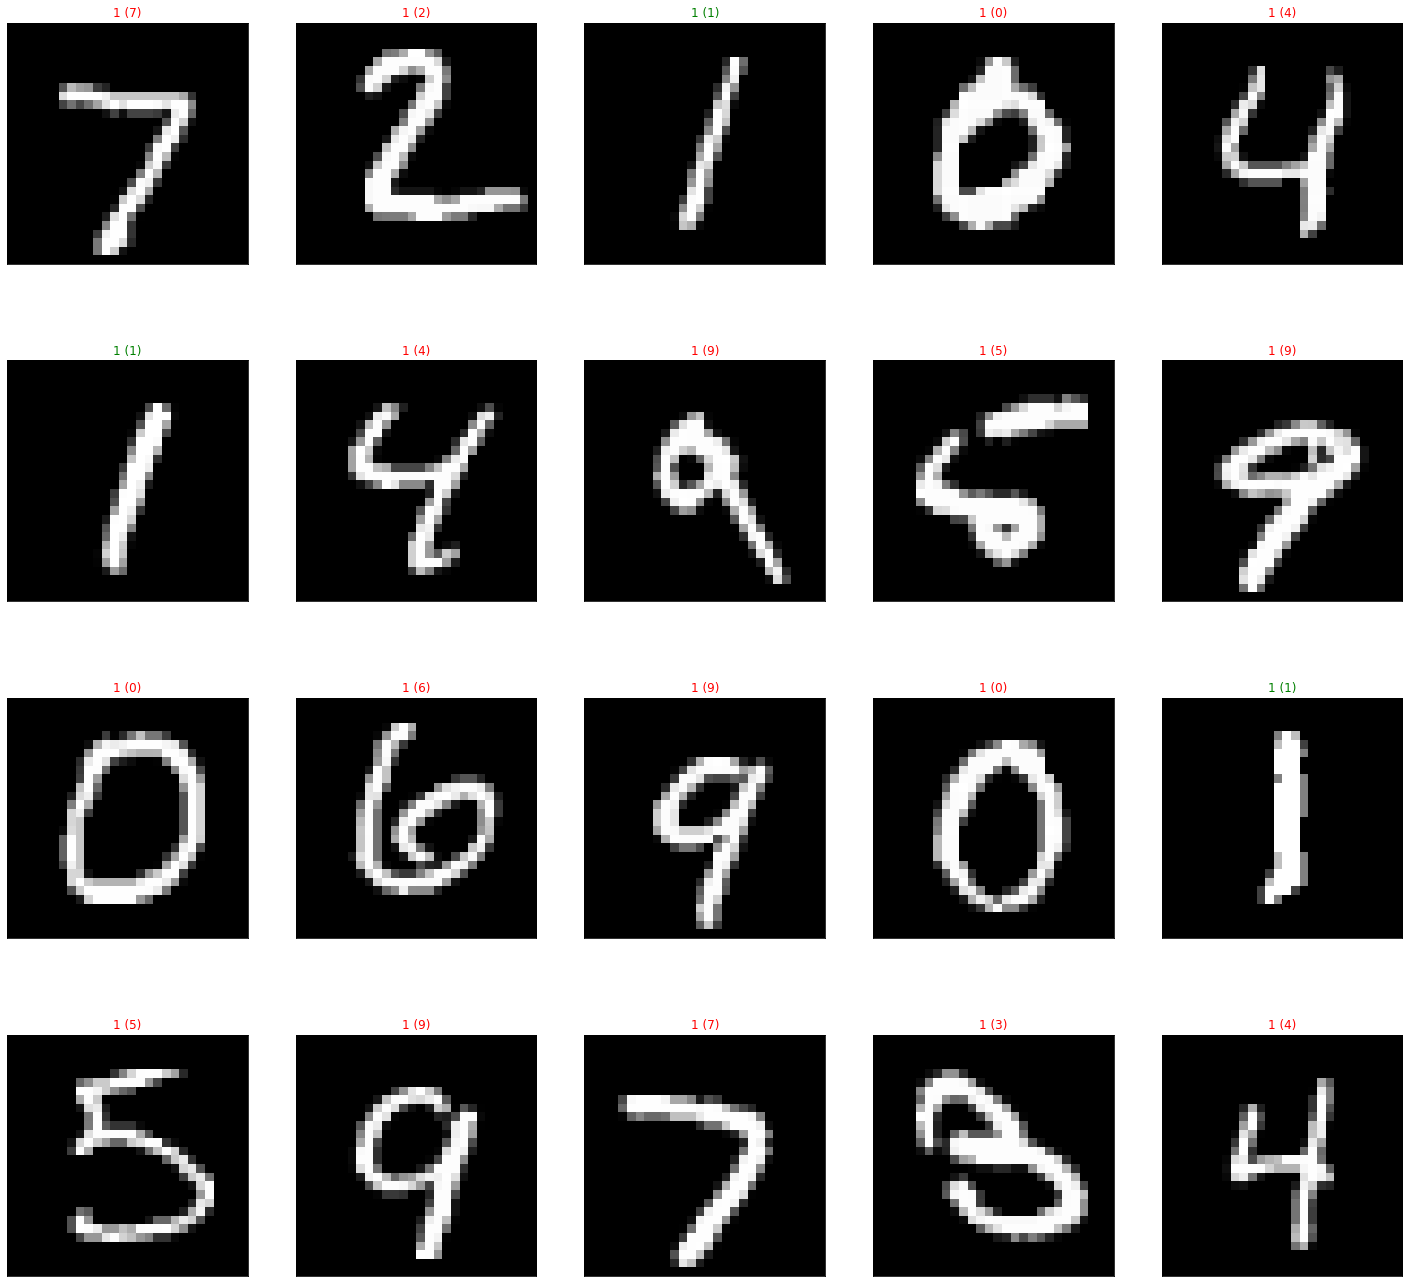

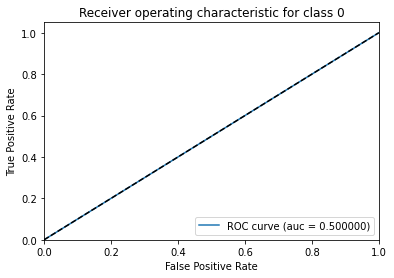

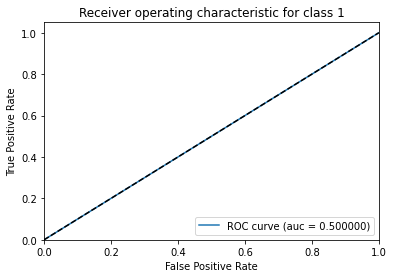

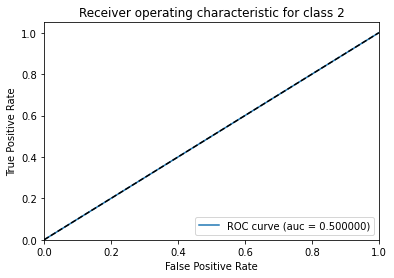

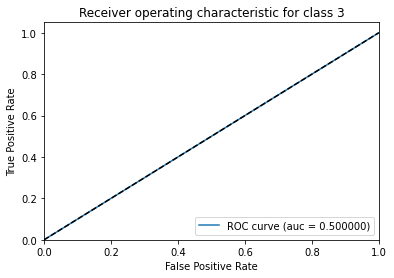

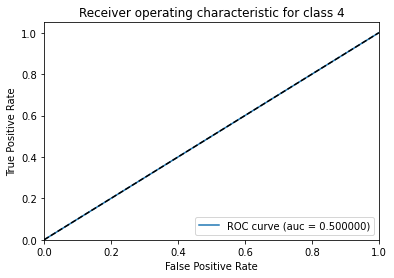

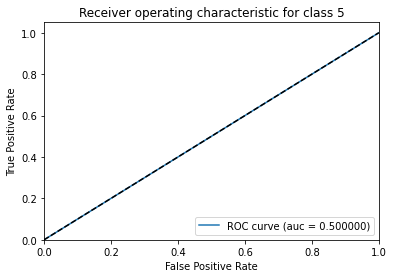

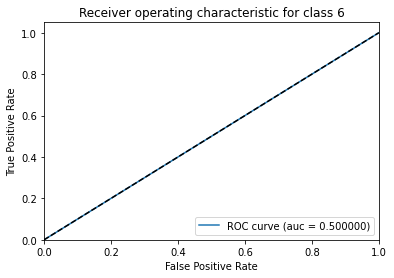

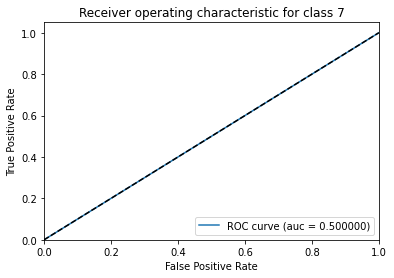

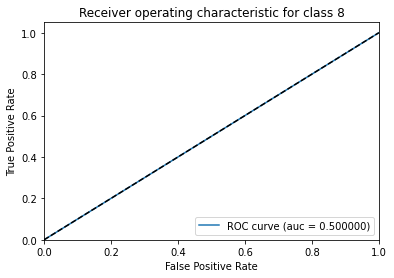

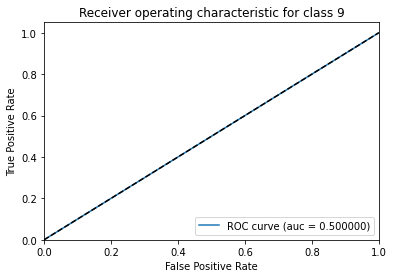



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


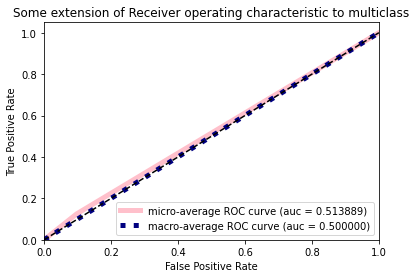

In [21]:
model16 = mlp_model("Tanh", "NLLLoss", "SGD", 10)

Tanh, NLLLoss, Adam

Activation function : Tanh
Loss function : NLLLoss
optimizer : Adam
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -242.2712
Epoch [1/10], Step [400/938], Loss: -729.0665
Epoch [1/10], Step [600/938], Loss: -1213.8212
Epoch [1/10], Step [800/938], Loss: -1698.7542
Epoch [2/10], Step [200/938], Loss: -2521.1413
Epoch [2/10], Step [400/938], Loss: -3006.2189
Epoch [2/10], Step [600/938], Loss: -3491.8871
Epoch [2/10], Step [800/938], Loss: -3975.0702
Epoch [3/10], Step [200/938], Loss: -4799.7433
Epoch [3/10], Step [400/938], Loss: -5283.1516
Epoch [3/10], Step [600/938], Loss: -5767.7121
Epoch [3/10], Step [800/938], Loss: -6253.6361
Epoch [4/10], Step [200/938], Loss: -7079.0779
Epoch [4/10], Step [400/938], Loss: -7560.9627
Epoch [4/10], Step [600/938], Loss: -8046.6999
Epoch [4/10], Step [800/938], Loss: -8531.6179
Epoch [5/10], Step [200/938], Loss: -9358.3942
Epoch [5/10]

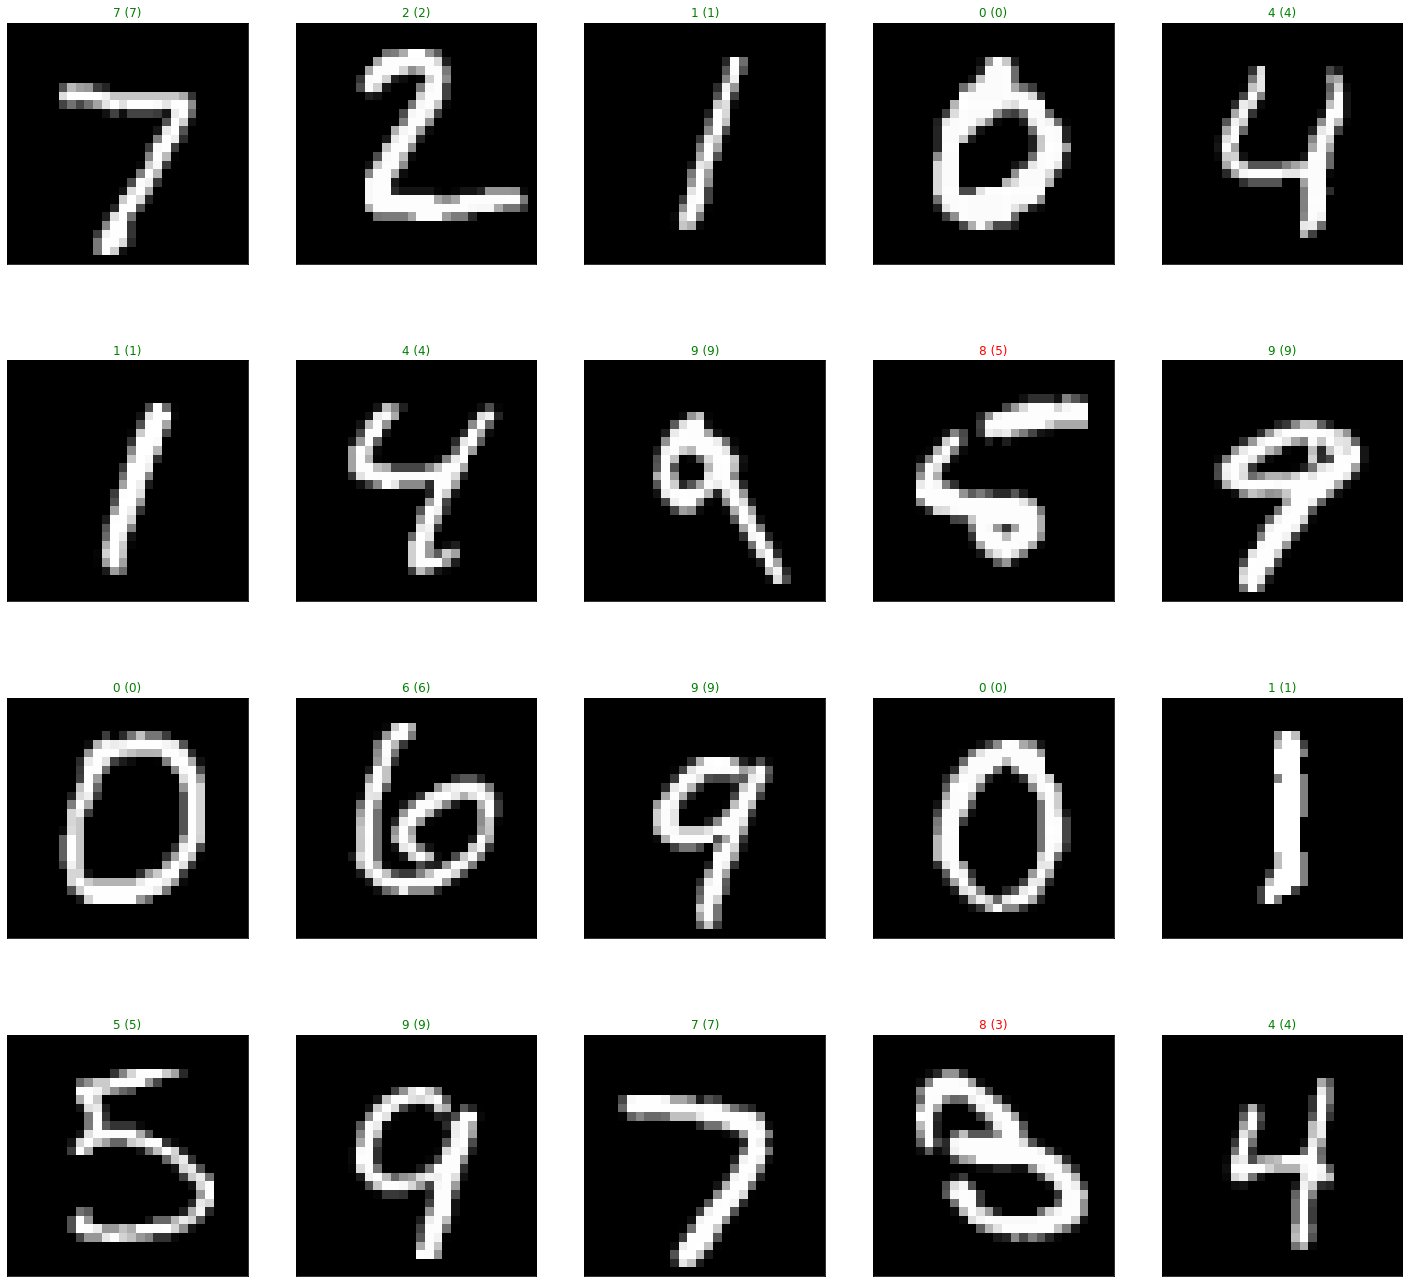

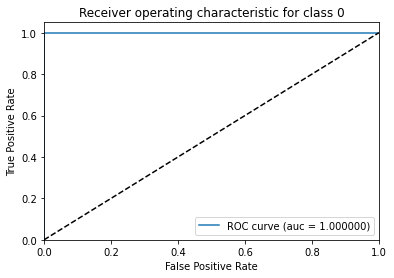

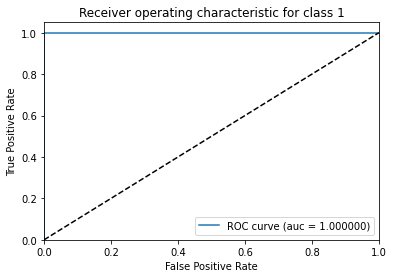

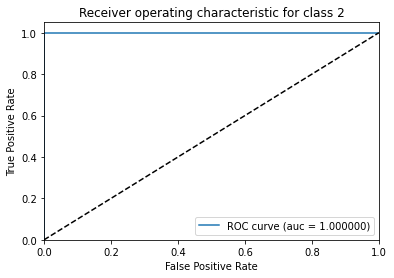

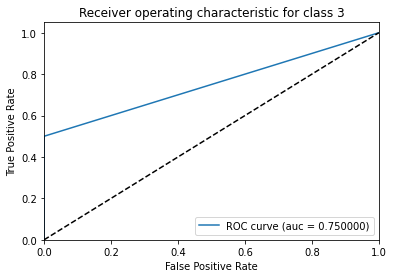

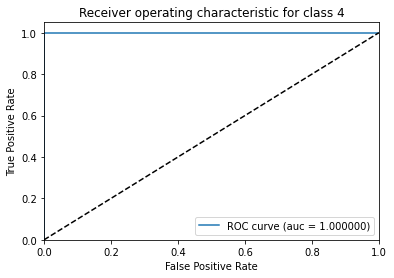

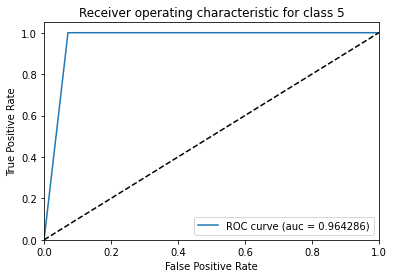

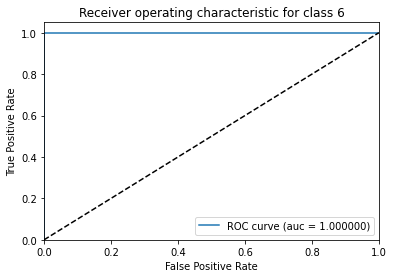

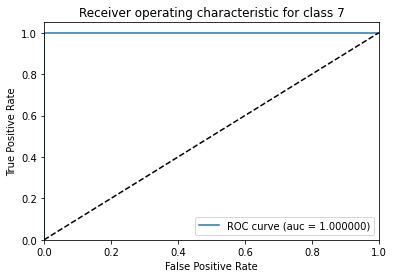

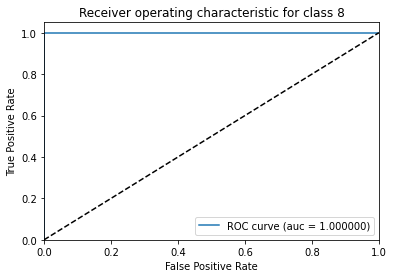

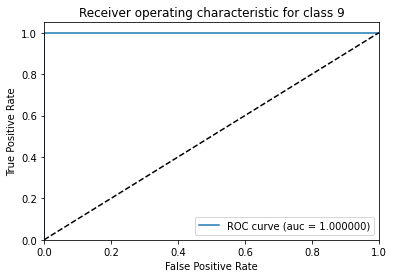



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


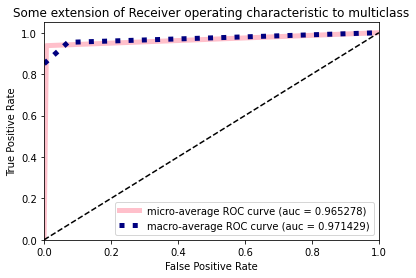

In [22]:
model17 = mlp_model("Tanh", "NLLLoss", "Adam", 10)

Tanh, NLLLoss, Adagrad

Activation function : Tanh
Loss function : NLLLoss
optimizer : Adagrad
Number of epochs : 10
----------------------------------------------------------------------------------------------------
Epoch [1/10], Step [200/938], Loss: -46.6862
Epoch [1/10], Step [400/938], Loss: -85.2219
Epoch [1/10], Step [600/938], Loss: -110.0230
Epoch [1/10], Step [800/938], Loss: -130.1175
Epoch [2/10], Step [200/938], Loss: -158.5252
Epoch [2/10], Step [400/938], Loss: -172.8789
Epoch [2/10], Step [600/938], Loss: -186.1364
Epoch [2/10], Step [800/938], Loss: -198.6381
Epoch [3/10], Step [200/938], Loss: -218.3396
Epoch [3/10], Step [400/938], Loss: -228.9188
Epoch [3/10], Step [600/938], Loss: -239.0225
Epoch [3/10], Step [800/938], Loss: -248.8889
Epoch [4/10], Step [200/938], Loss: -264.9519
Epoch [4/10], Step [400/938], Loss: -273.6915
Epoch [4/10], Step [600/938], Loss: -282.1426
Epoch [4/10], Step [800/938], Loss: -290.5594
Epoch [5/10], Step [200/938], Loss: -304.5017
Epoch [5/10], Step [400/93

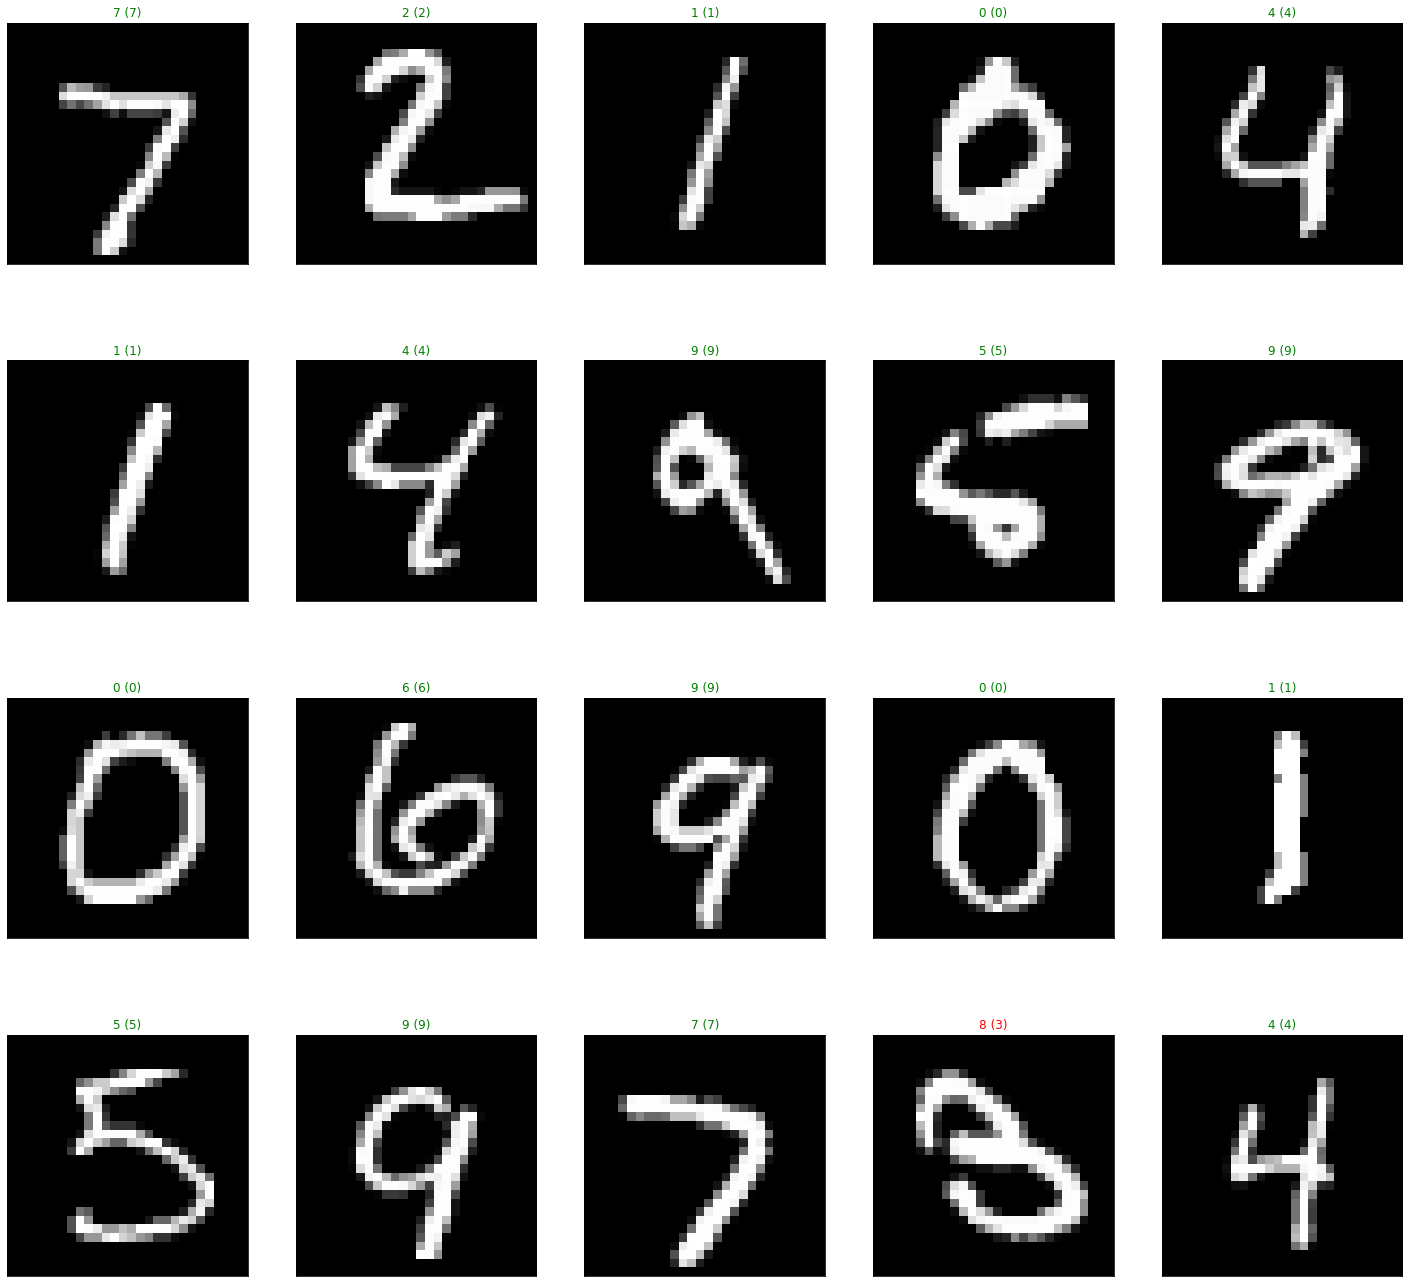

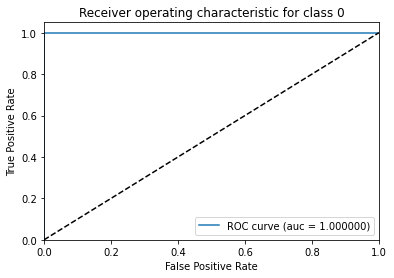

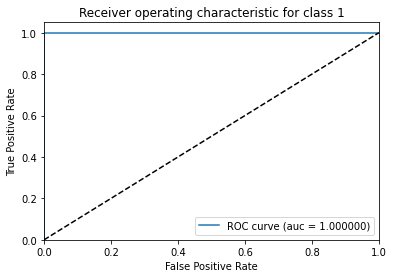

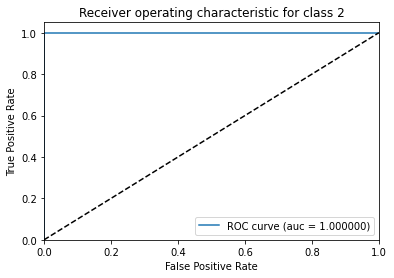

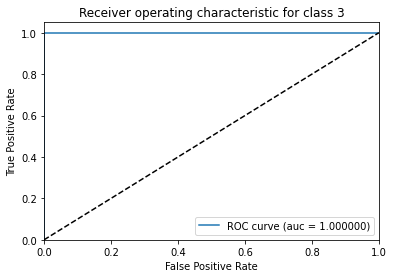

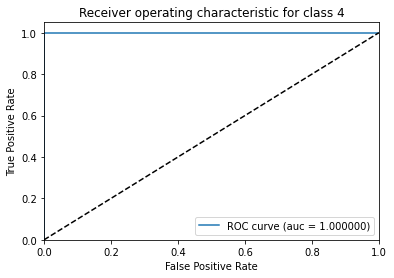

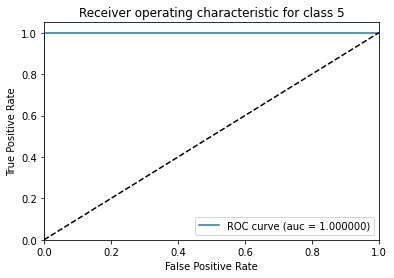

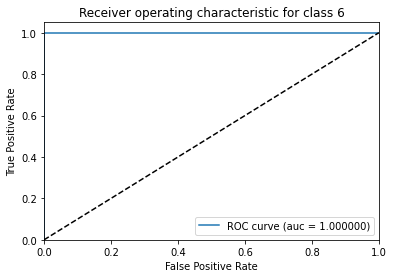

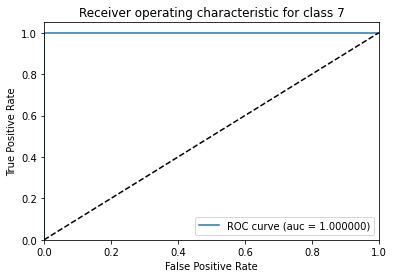

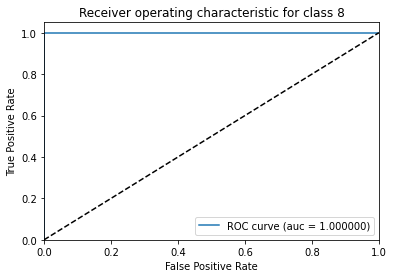

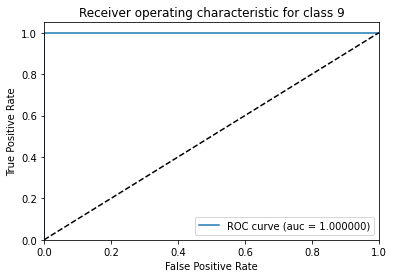



----------------------------------------------------------------------------------------------------


<ipython-input-5-e32e9d4e2cb0>:222: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


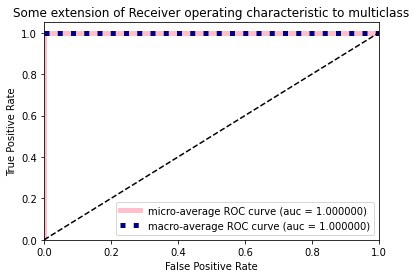

In [23]:
model18 = mlp_model("Tanh", "NLLLoss", "Adagrad", 10)